In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import train_test_split, cross_val_score 
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from collections import defaultdict


def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
df0 = pd.read_csv('complessivo_rms_finale.csv', index_col='id')
df1 = pd.read_csv('flat_df_no_nulli.csv', index_col=0)

### Multiclasse

### Binario

In [3]:
df1 = df1.drop(columns=[col if col != 'TRACK_genre_top' else "TRACK_genres_all" for col in df1.columns]).dropna()

df1['TRACK_genre_top_num'] = [1 if genre == "Rock" else 0 for genre in df1["TRACK_genre_top"]]

In [4]:
df = pd.merge(df1.TRACK_genre_top_num, df0, left_index=True, right_index=True)

#per la ram
df0 = None
df1  =None

df

,TRACK_genre_top_num,0,1,2,3,4,5,6,7,8,...,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291
2,0,0.005965,0.030530,0.038409,0.052510,0.081335,0.096664,0.092021,0.083451,0.083296,...,0.167174,0.126127,0.111858,0.095006,0.099327,0.097803,0.107587,0.152822,0.177150,0.000000
3,0,0.009710,0.088201,0.120011,0.128533,0.150989,0.169258,0.205793,0.261233,0.279276,...,0.126499,0.103162,0.147984,0.207548,0.256682,0.254089,0.194205,0.146202,0.119663,0.121850
5,0,0.004292,0.036312,0.051975,0.046670,0.203390,0.283229,0.314644,0.322023,0.293859,...,0.318426,0.312173,0.305558,0.281919,0.234308,0.178978,0.163058,0.143980,0.120217,0.107188
10,0,0.110271,0.142744,0.156790,0.131847,0.125279,0.129176,0.128395,0.171358,0.298087,...,0.296138,0.217364,0.184314,0.176318,0.161866,0.158079,0.158619,0.148111,0.146005,0.000000
134,0,0.030768,0.152135,0.199774,0.269876,0.375679,0.391104,0.359060,0.326591,0.276587,...,0.085308,0.058013,0.057826,0.070345,0.089812,0.085378,0.086922,0.105205,0.105316,0.090875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155315,1,0.158557,0.158167,0.145906,0.162589,0.188191,0.173111,0.155064,0.165688,0.173078,...,0.026859,0.027577,0.024202,0.023801,0.025244,0.025122,0.021450,0.018870,0.017375,0.018515
155316,1,0.127192,0.209792,0.245813,0.218415,0.202730,0.186682,0.181166,0.170364,0.171622,...,0.177781,0.196609,0.196542,0.175911,0.152180,0.142664,0.140520,0.136186,0.171844,0.185346
155317,1,0.124034,0.126594,0.129472,0.126551,0.120213,0.125967,0.148710,0.156304,0.137944,...,0.068987,0.070163,0.073941,0.072122,0.074395,0.076910,0.077558,0.078151,0.076024,0.077503
155318,1,0.106511,0.103265,0.105738,0.119232,0.133367,0.139314,0.132606,0.124244,0.125047,...,0.205924,0.127026,0.125577,0.114014,0.104968,0.097456,0.094659,0.112066,0.122239,0.115811


In [5]:
#Ho 1292 sample estratti facendo la media ogni 512 posizioni di 1024 valori.
#I sample originali erano 22050*30s
#Ogni sample estratto rappresenta 23.22 ms di canzone
#Con shapelet lunghe 44 rappresento 1,02s di canzone, di conseguenza definisco:

LEN_S = list()

for i in range(30):
    LEN_S.append(44*i)

#Si usa mettendo nelle [] il numero di secondi
LEN_S[2]

88

In [6]:
class_name = 'TRACK_genre_top_num'

X = df.drop(columns=["TRACK_genre_top_num"]).values
y = df[class_name]

scaler = TimeSeriesScalerMeanVariance(mu=0, std=1.)
X = scaler.fit_transform(X).reshape(X.shape[0], X.shape[1])

#scaler = TimeSeriesScalerMinMax()
#X = scaler.fit_transform(X).reshape(X.shape[0], X.shape[1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100, stratify=y)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 12730, 1: 12730})


In [7]:
from keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

C:\Users\cri98\anaconda3\lib\site-packages\tslearn\clustering\kmeans.py:16: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


In [8]:
n_ts, ts_sz = X.shape
n_classes = len(set(y))

# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=1/30, #1s
                                                       r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 49229
ts_sz 1292
n_classes 2
shapelet_sizes {43: 7}


def prova(reg):
    print(reg)
    shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                            optimizer="AdaDelta",
                            weight_regularizer=reg,
                            max_iter=50, #.01 f .86 <--> .025 t .82
                            scale = True,
                            verbose=1)

    shp_clf.fit(X_res, y_res)
    
    y_pred = shp_clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

#result = {}
for i in range(30, 30+1, 5):
    result[i/1000.0] = prova(i/1000.0)

result

In [9]:
#migliore .01 f .86
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                            optimizer="AdaDelta",
                            weight_regularizer=.01,
                            max_iter=50,
                            verbose=1)

shp_clf.fit(X_res, y_res)

y_pred = shp_clf.predict(X_test)

C:\Users\cri98\anaconda3\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Epoch 1/50
100/100 [==============================] - 4s 9ms/step - loss: 0.7141 - binary_accuracy: 0.4718 - binary_crossentropy: 0.7009
Epoch 2/50
100/100 [==============================] - 1s 9ms/step - loss: 0.7141 - binary_accuracy: 0.4738 - binary_crossentropy: 0.7009
Epoch 3/50
100/100 [==============================] - 1s 9ms/step - loss: 0.7133 - binary_accuracy: 0.4729 - binary_crossentropy: 0.7001
Epoch 4/50
100/100 [==============================] - 1s 9ms/step - loss: 0.7147 - binary_accuracy: 0.4667 - binary_crossentropy: 0.7015
Epoch 5/50
100/100 [==============================] - 1s 9ms/step - loss: 0.7135 - binary_accuracy: 0.4725 - binary_crossentropy: 0.7003
Epoch 6/50
100/100 [==============================] - 1s 9ms/step - loss: 0.7147 - binary_accuracy: 0.4671 - binary_crossentropy: 0.7015
Epoch 7/50
100/100 [==============================] - 1s 9ms/step - loss: 0.7136 - binary_accuracy: 0.4738 - binary_crossentropy: 0.7004
Epoch 8/50
100/100 [=====================

In [10]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.43611618931545804
F1-score [0.49435337 0.36271809]
              precision    recall  f1-score   support

           0       0.68      0.39      0.49      3508
           1       0.27      0.56      0.36      1415

    accuracy                           0.44      4923
   macro avg       0.48      0.47      0.43      4923
weighted avg       0.57      0.44      0.46      4923



In [67]:
from sklearn.metrics import accuracy_score

predicted_labels = shp_clf.predict(X)
predicted_locations = shp_clf.locate(X)
print("Correct classification rate:", accuracy_score(y, predicted_labels))

193/193 [==============================] - 1s 5ms/step
Correct classification rate: 0.4026285319628674


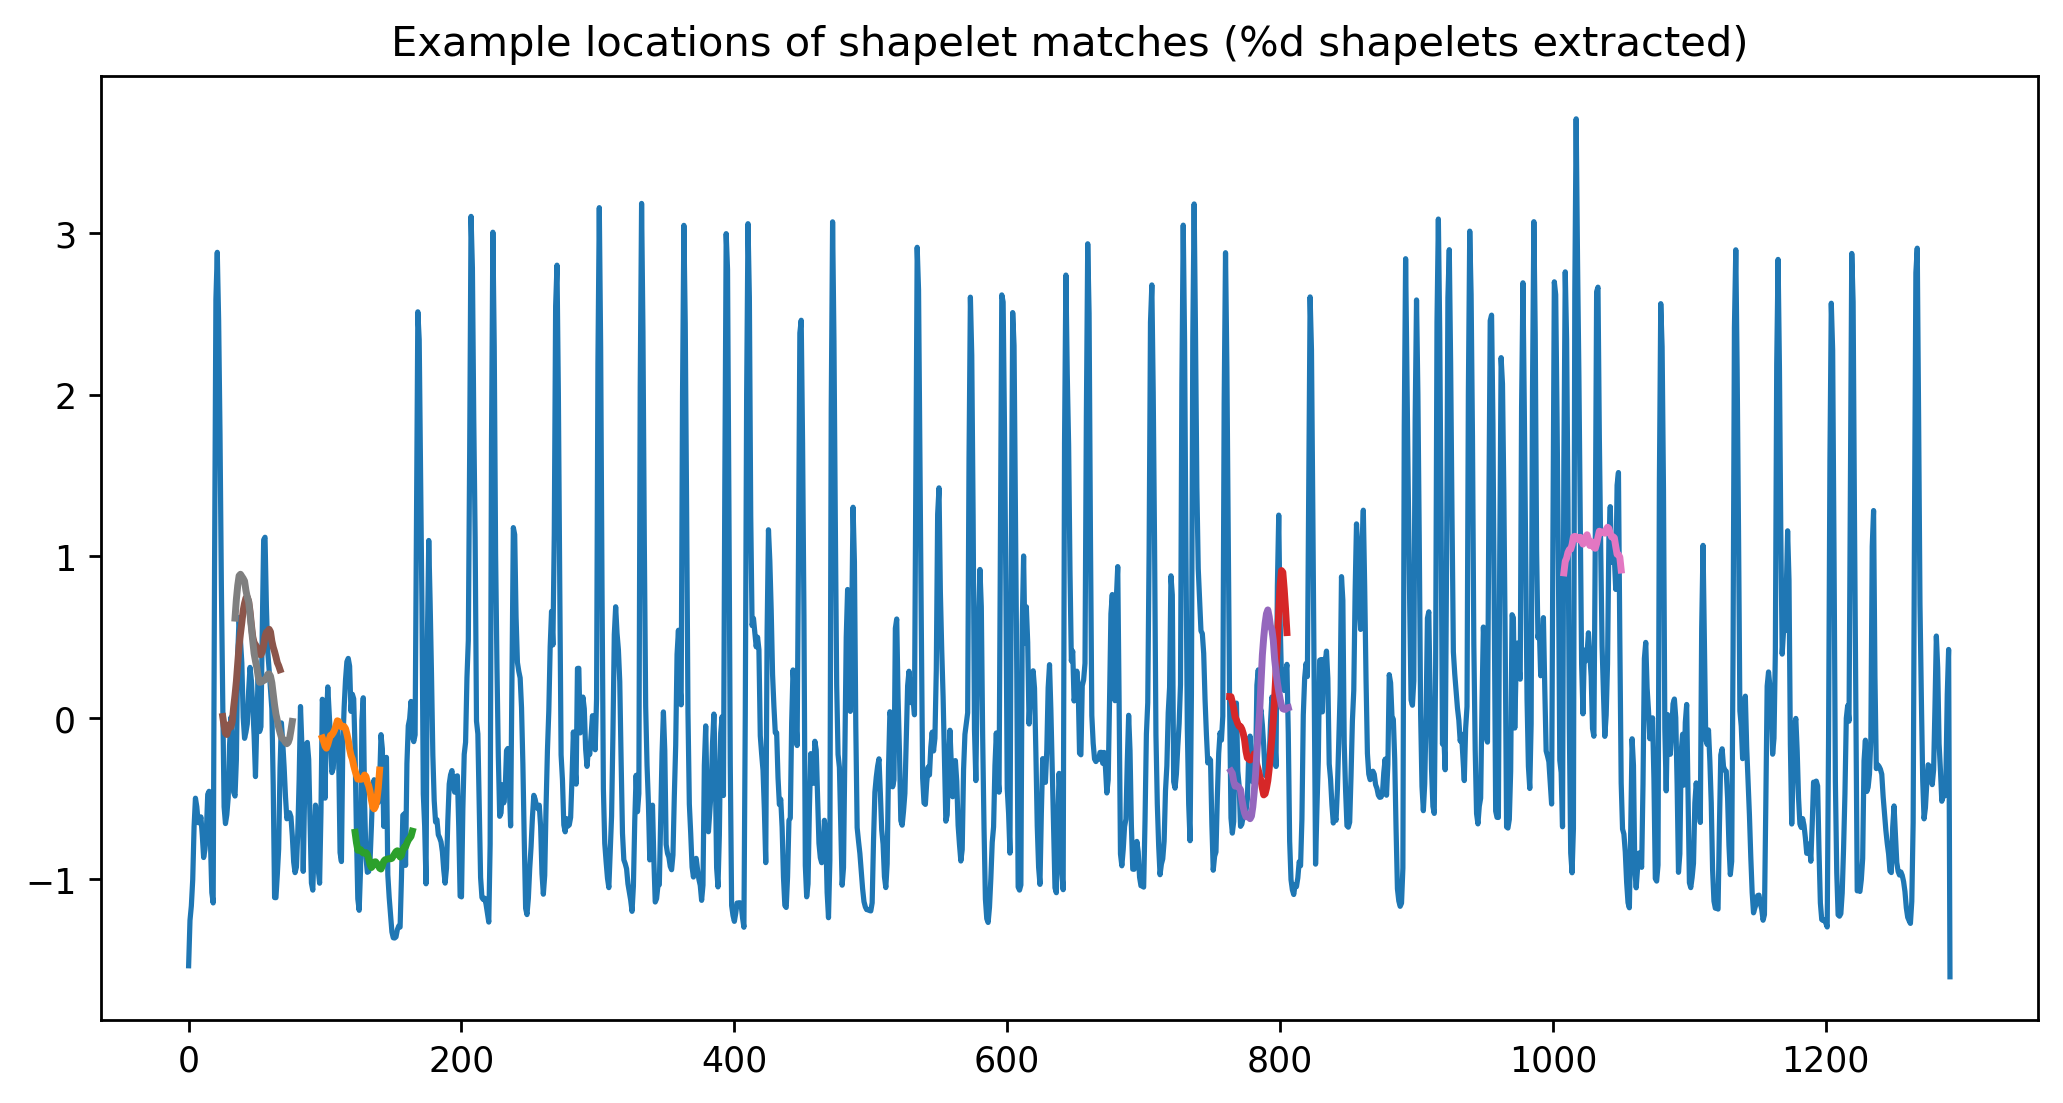

In [68]:
ts_id = 0
plt.figure()
n_shapelets = sum(shapelet_sizes.values())
plt.title("Example locations of shapelet matches "
          "(%d shapelets extracted)".format(n_shapelets))

plt.plot(X[ts_id].ravel())
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)

0


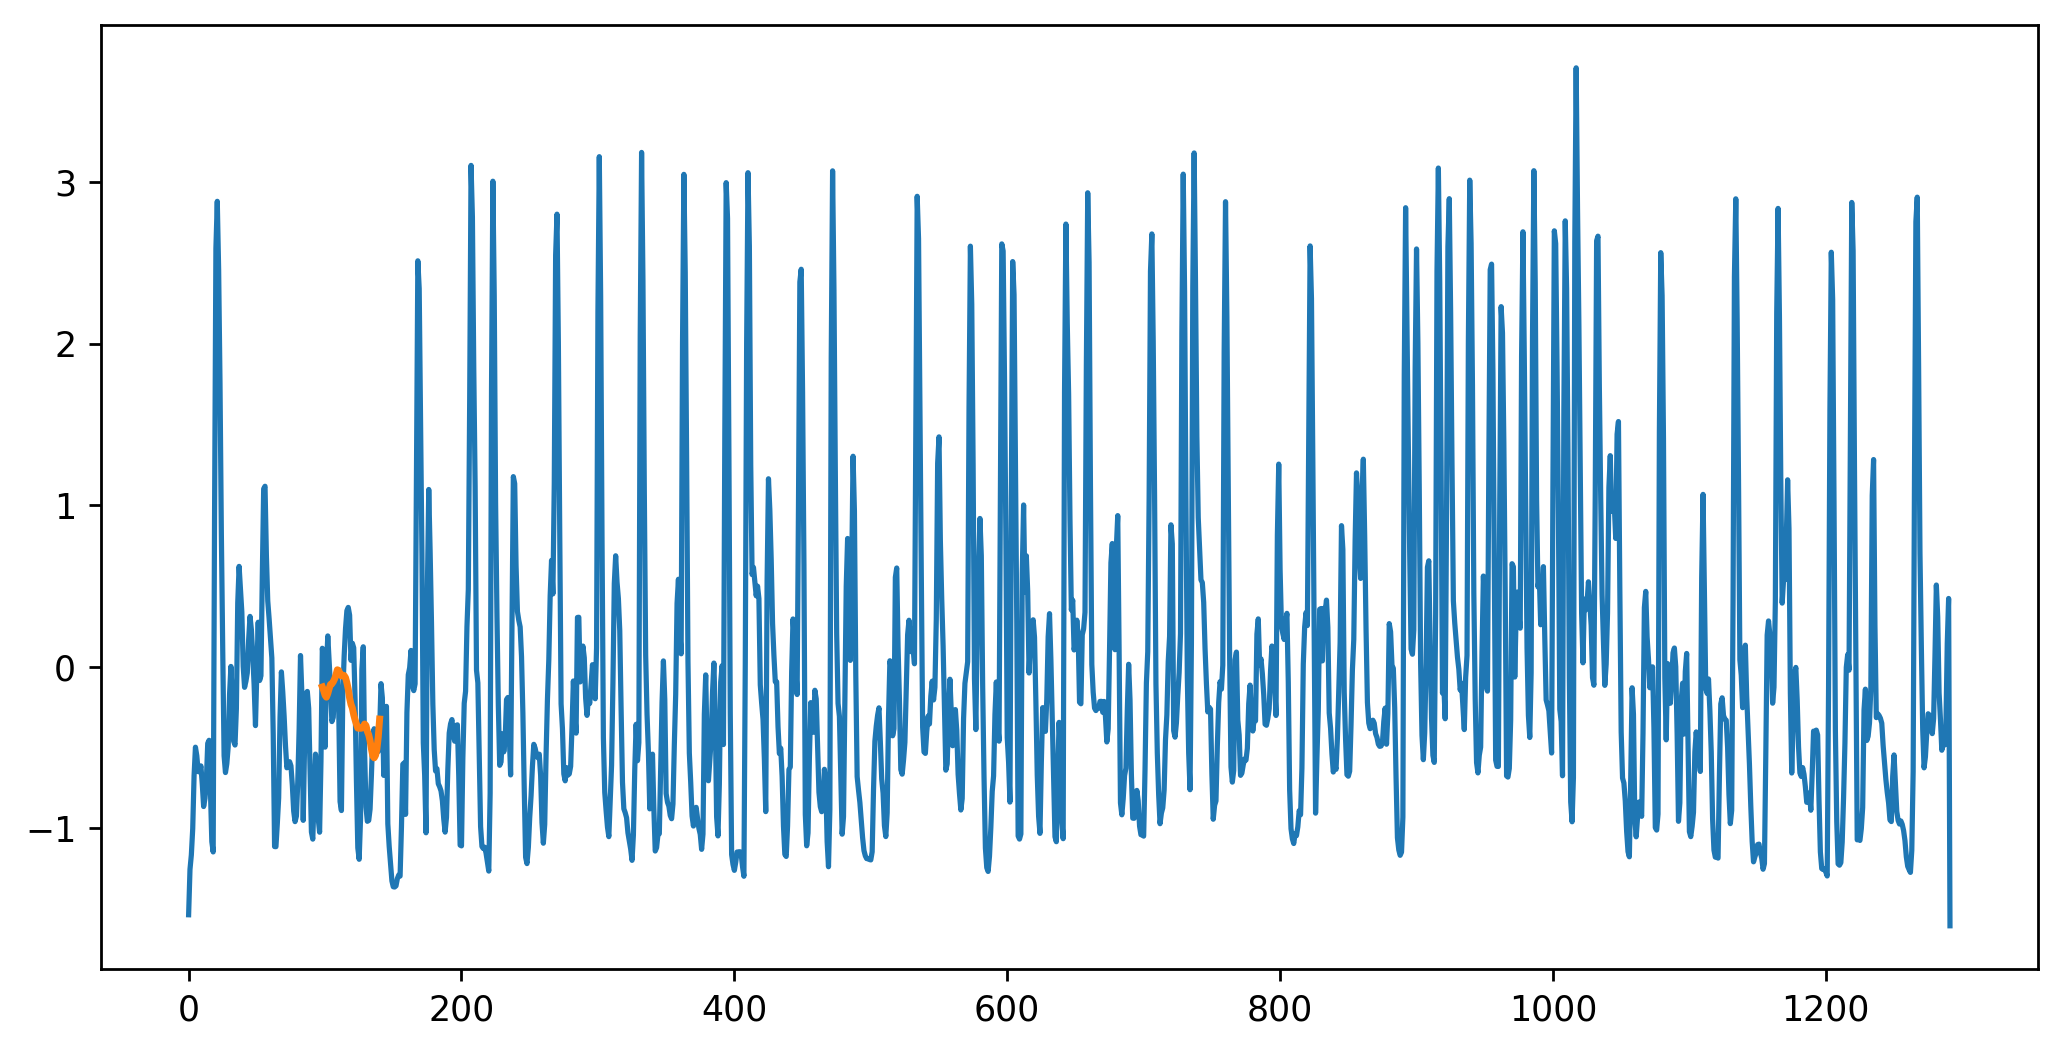

1


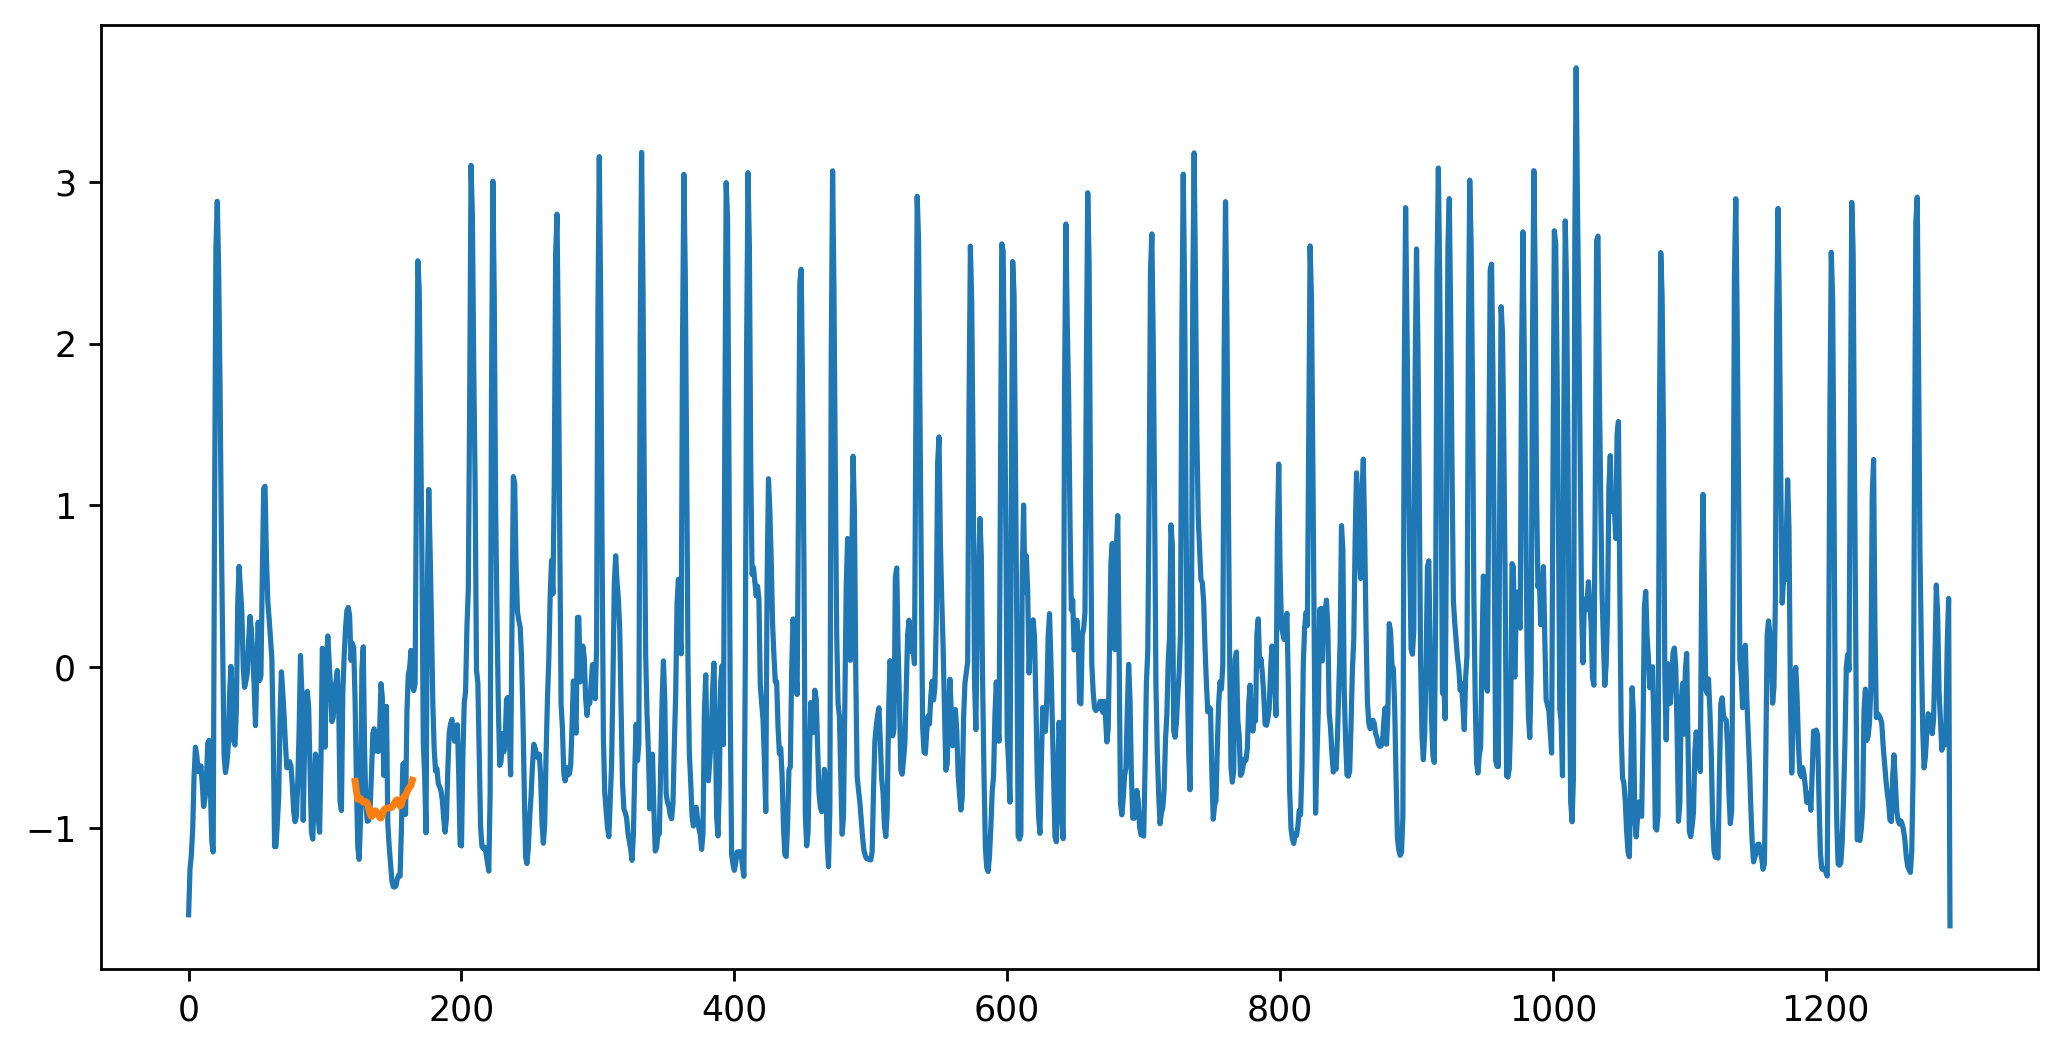

2


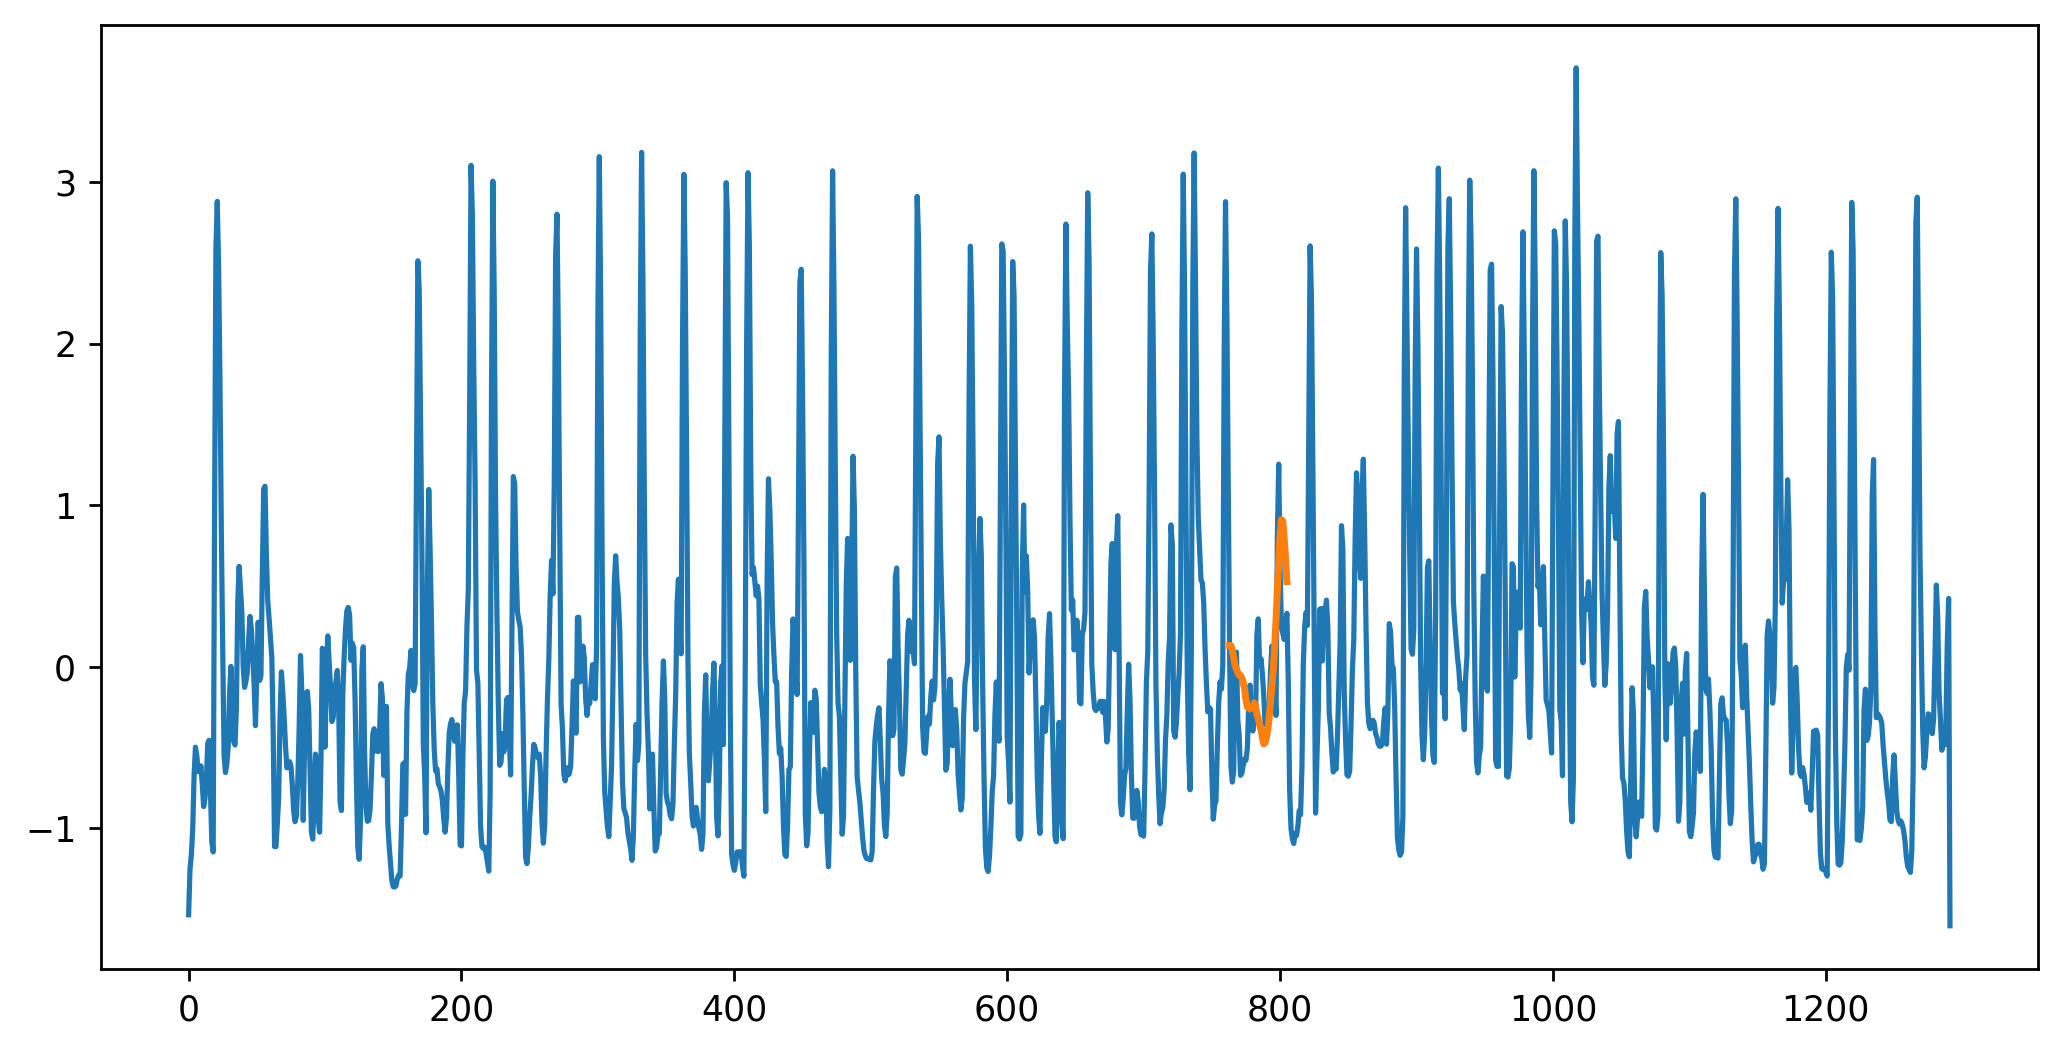

3


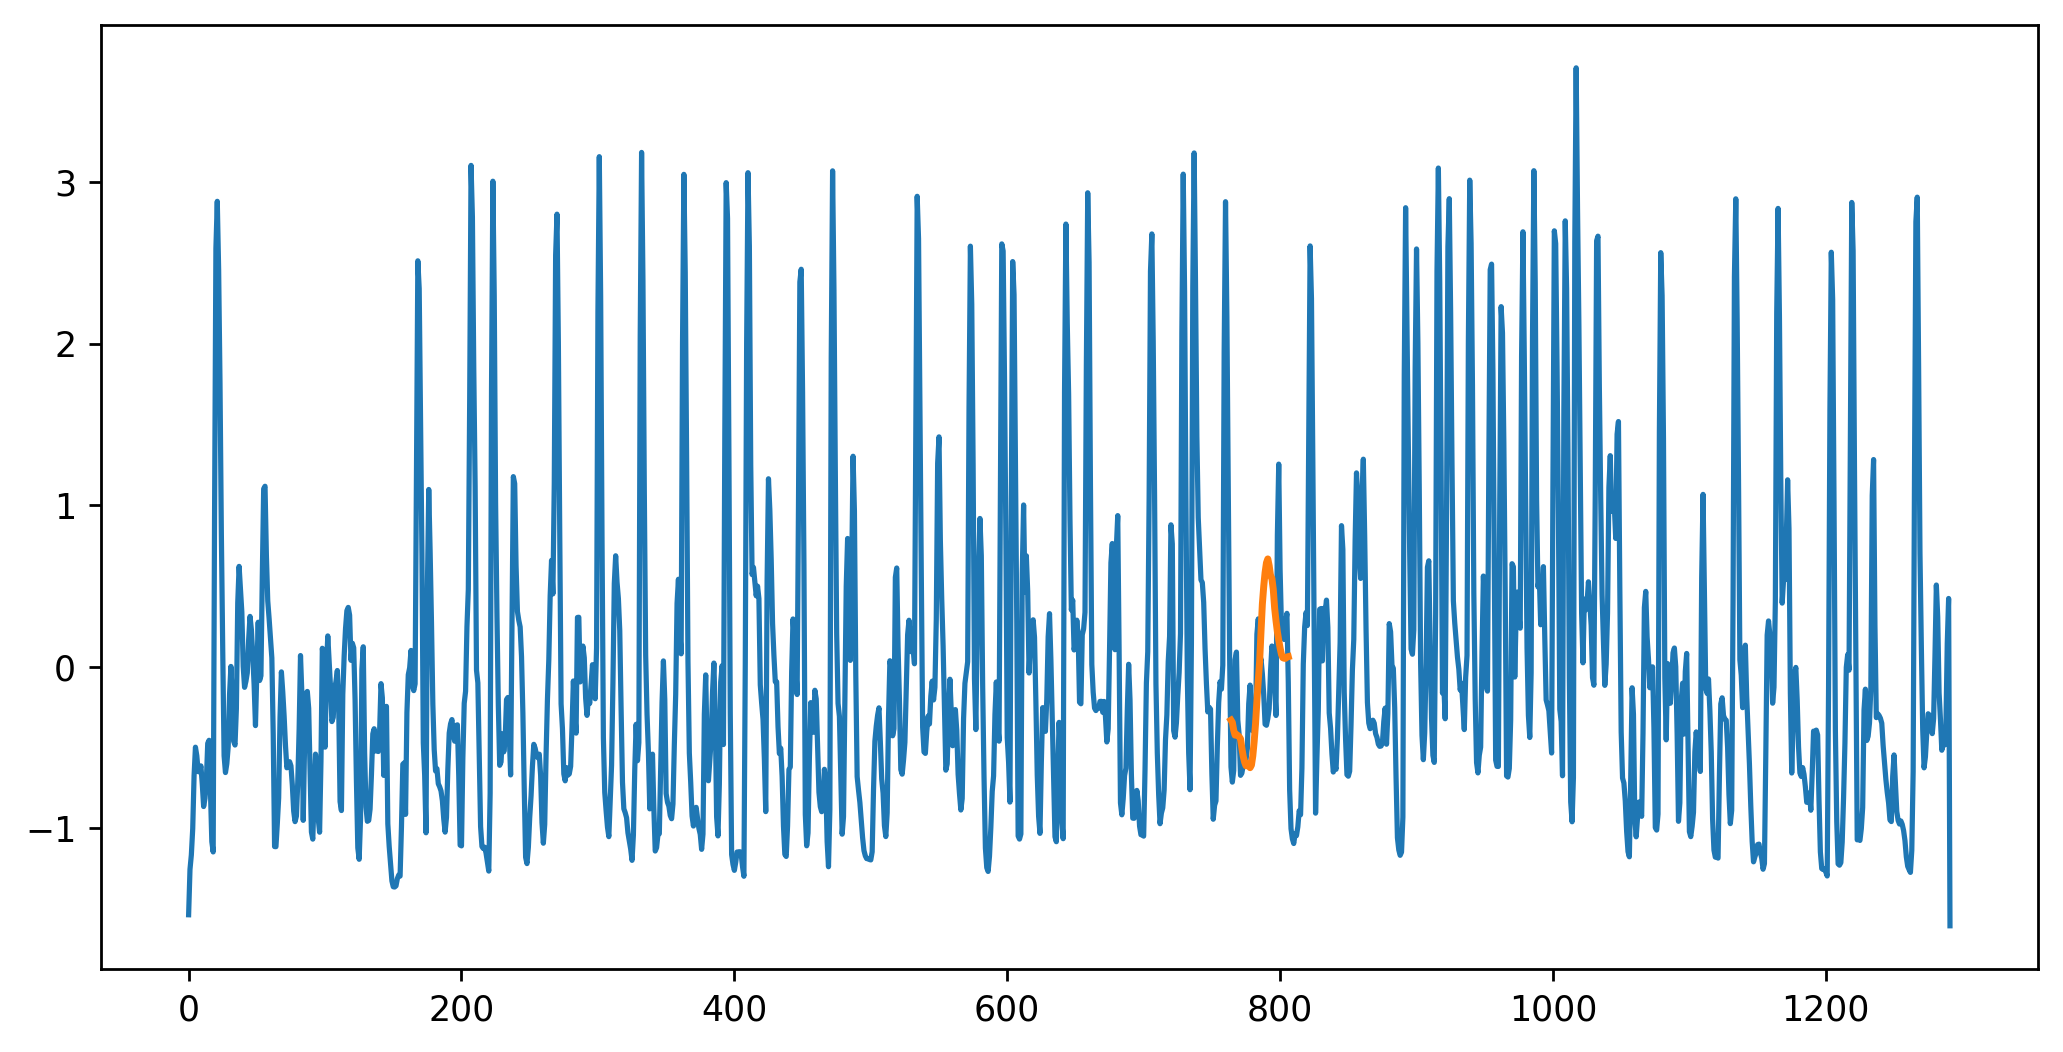

4


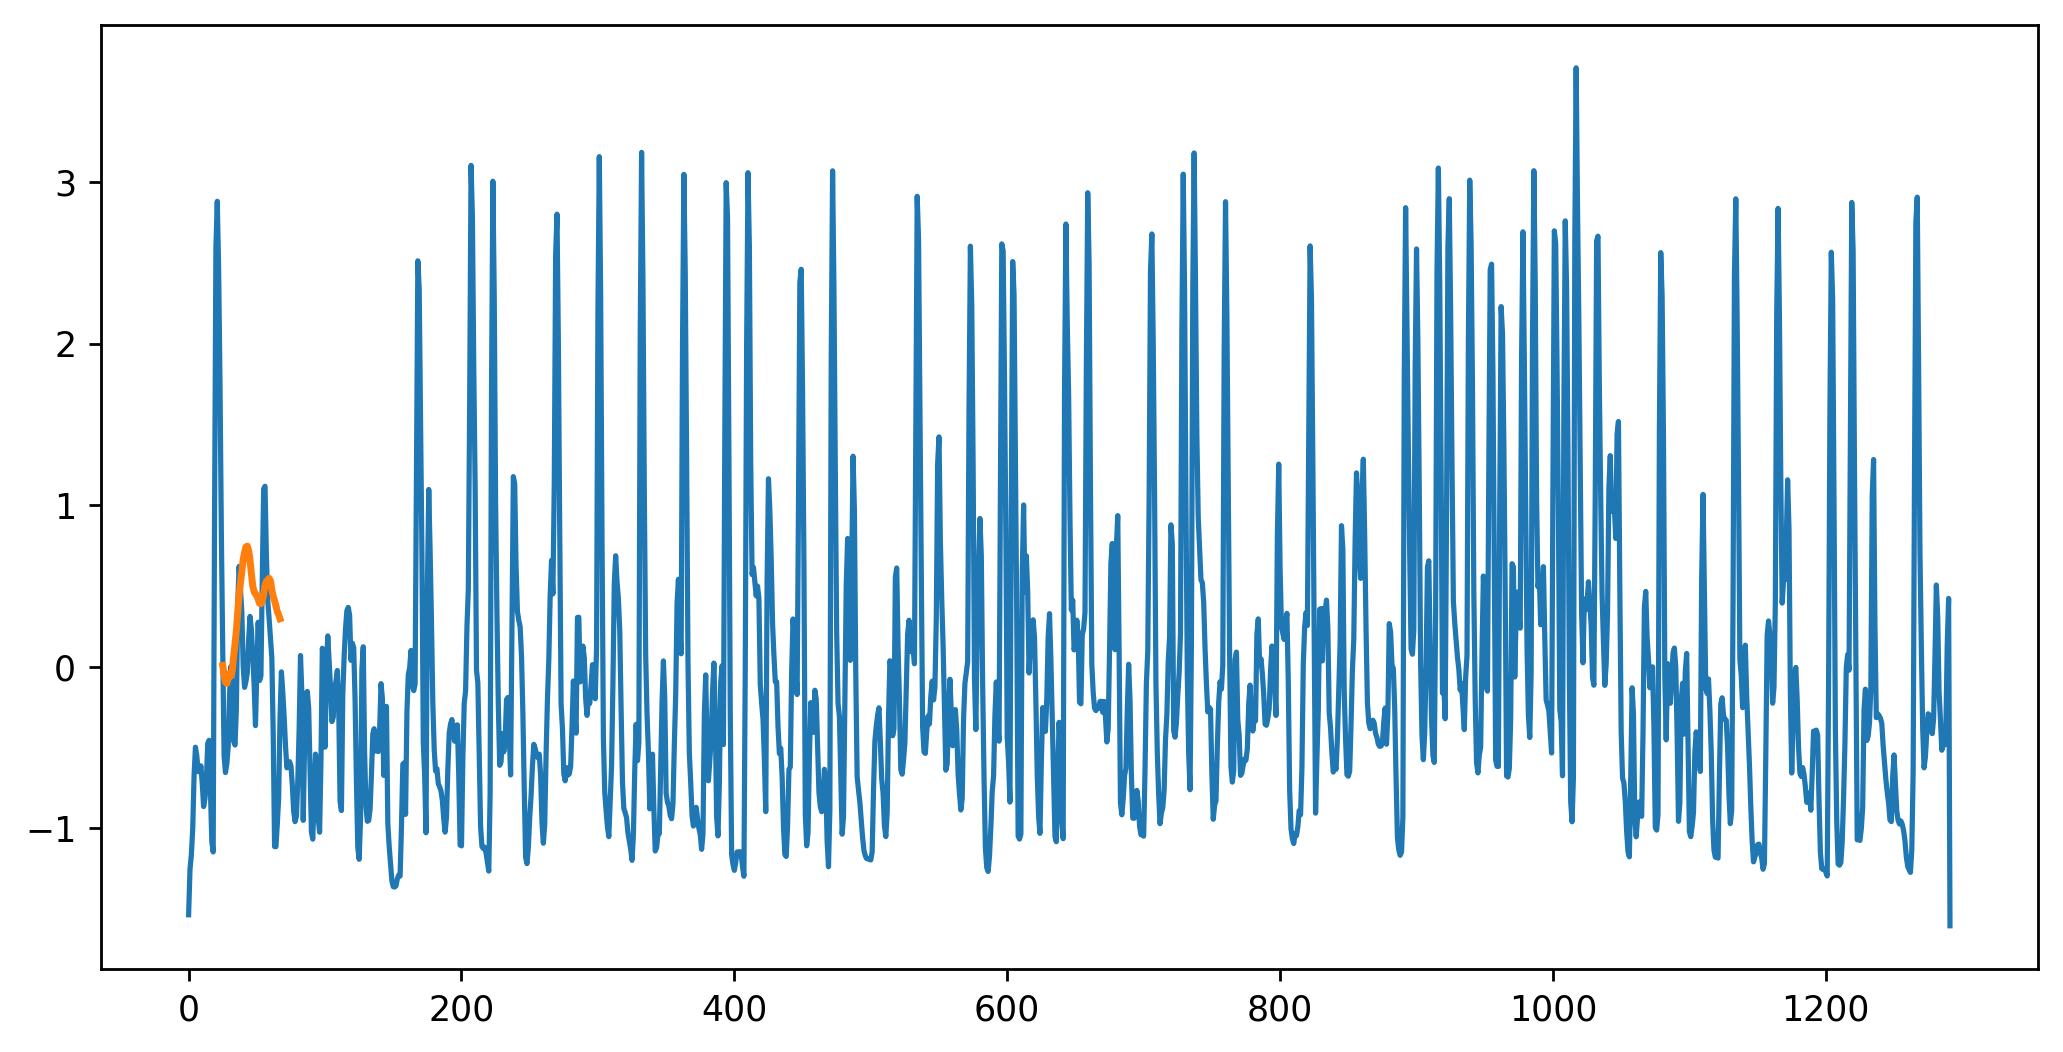

5


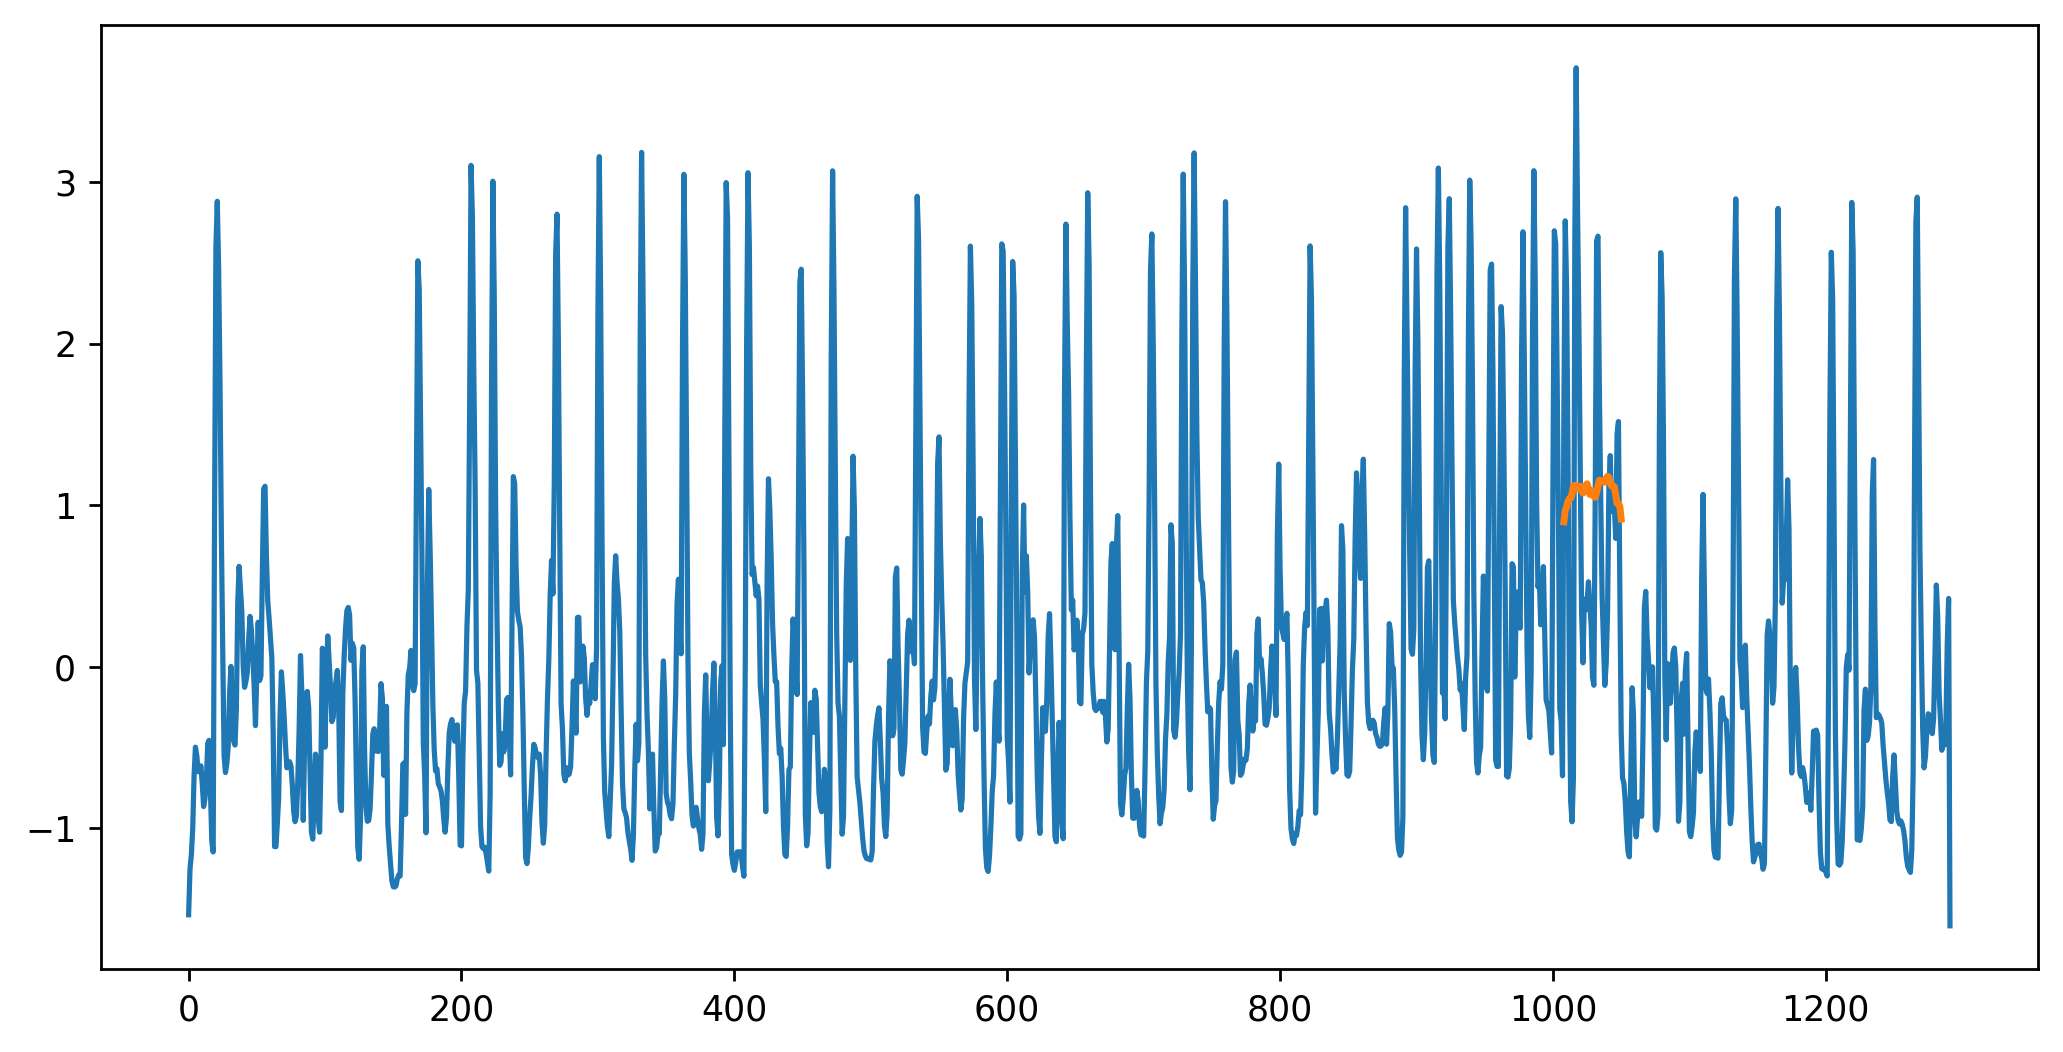

6


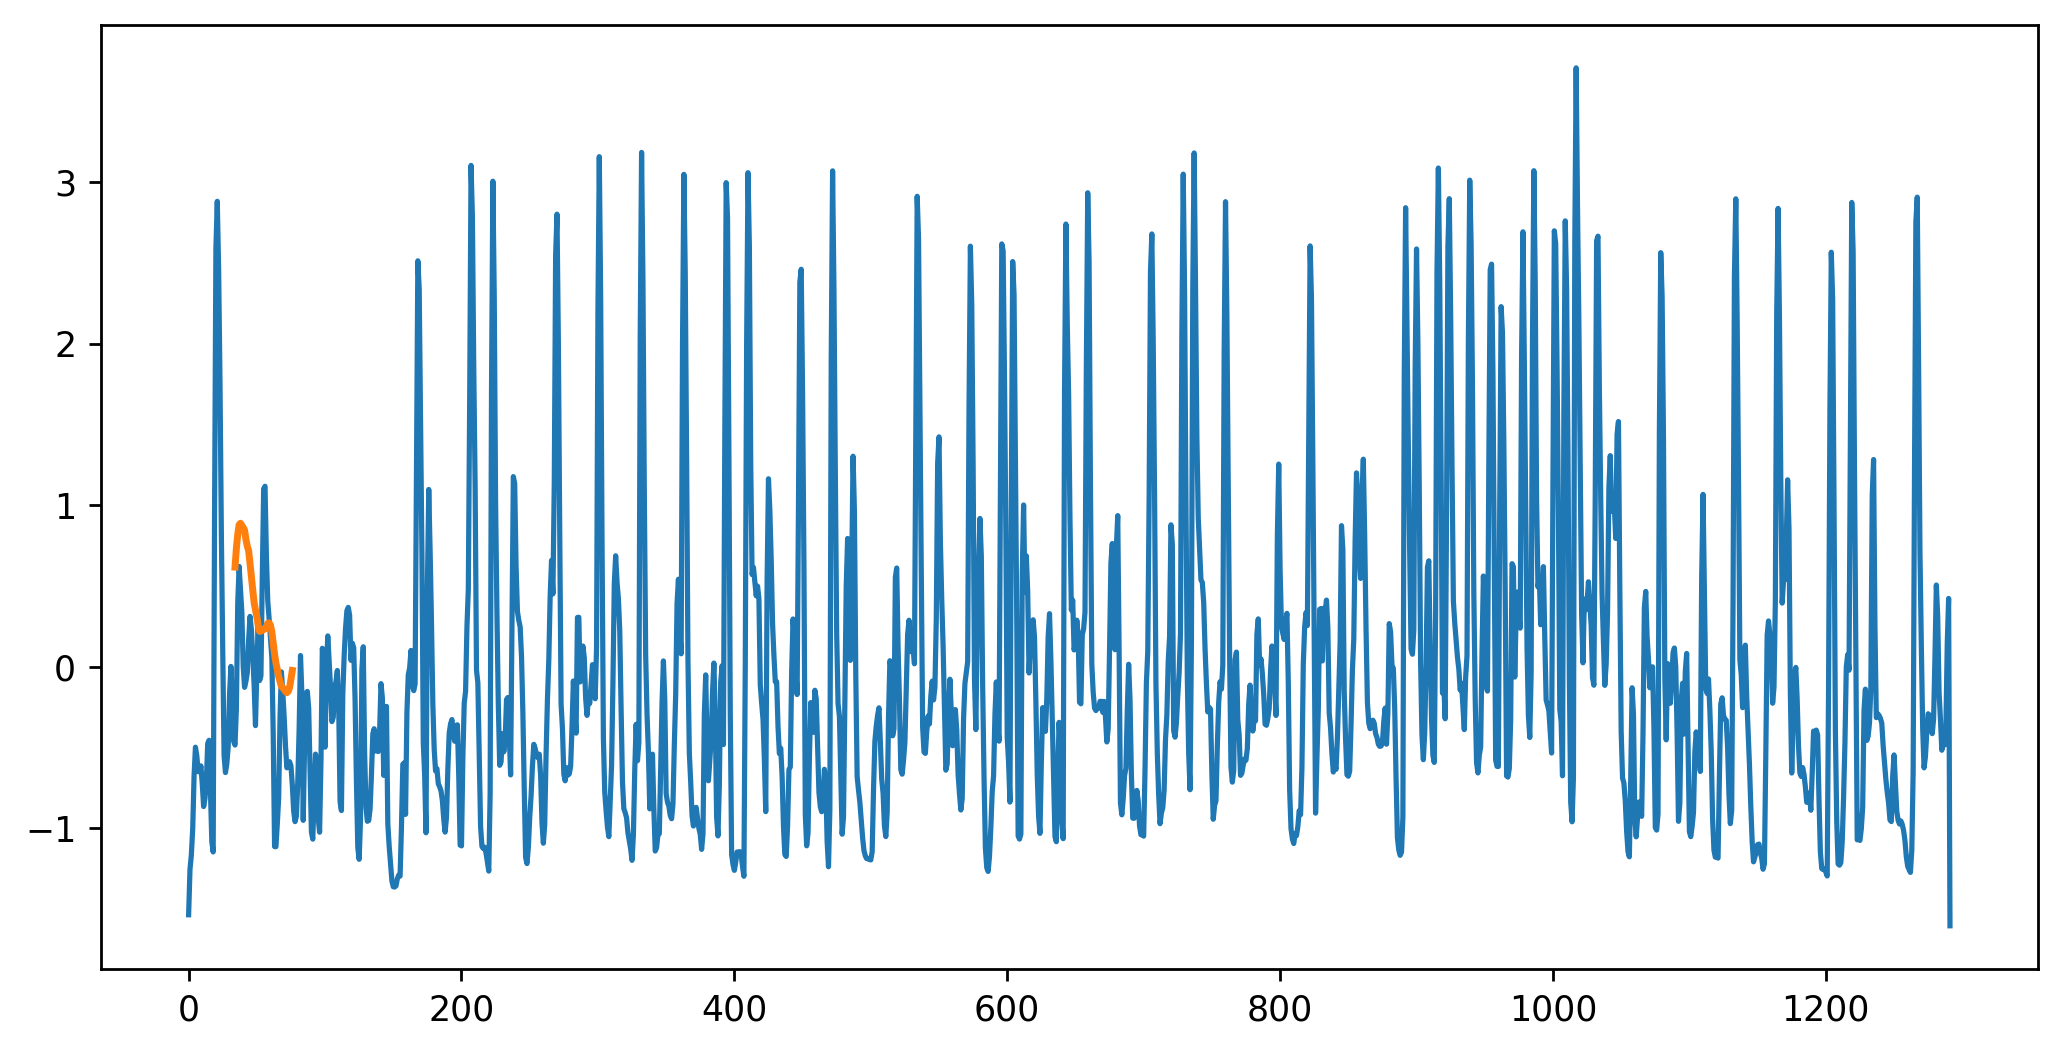

In [69]:
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    plt.plot(X[ts_id].ravel())
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)
    print(idx_shp)
    plt.show()

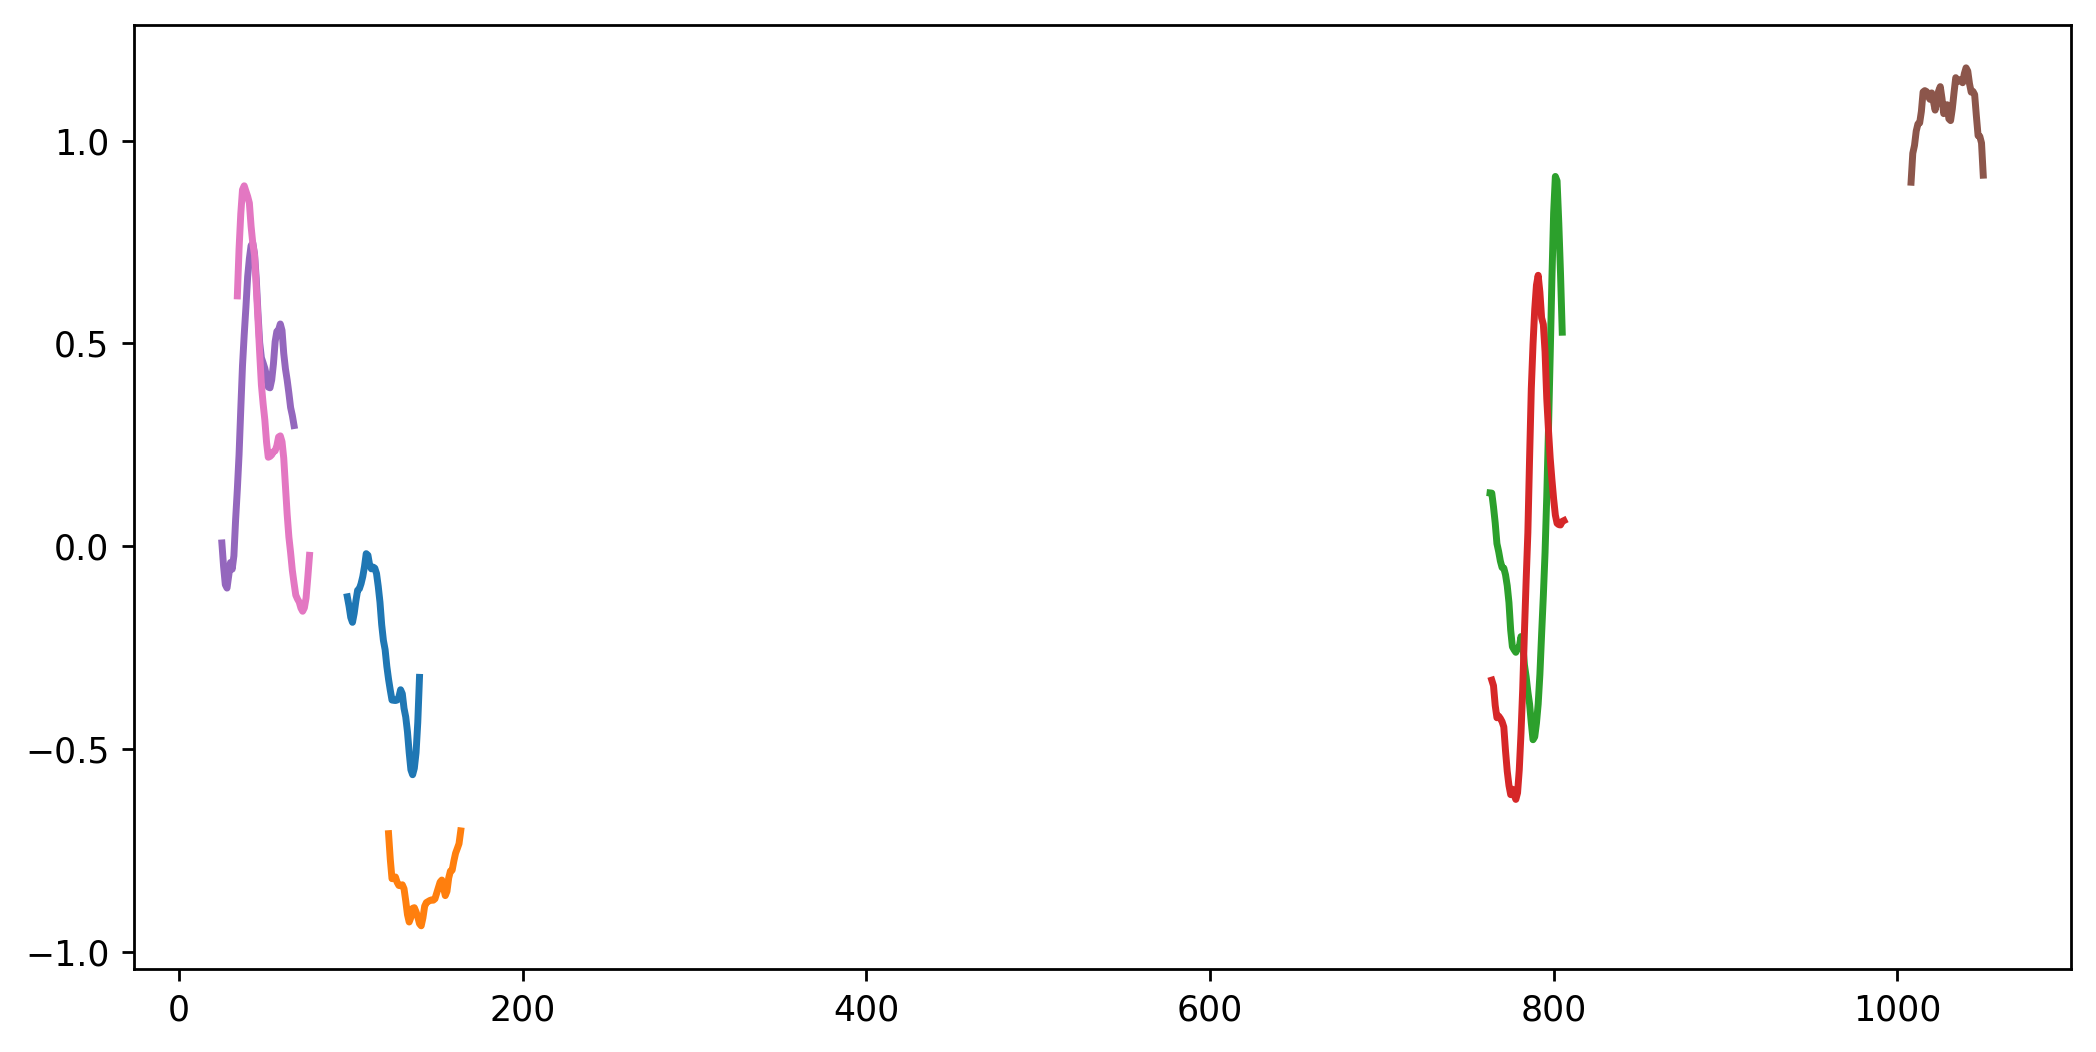

In [70]:
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)

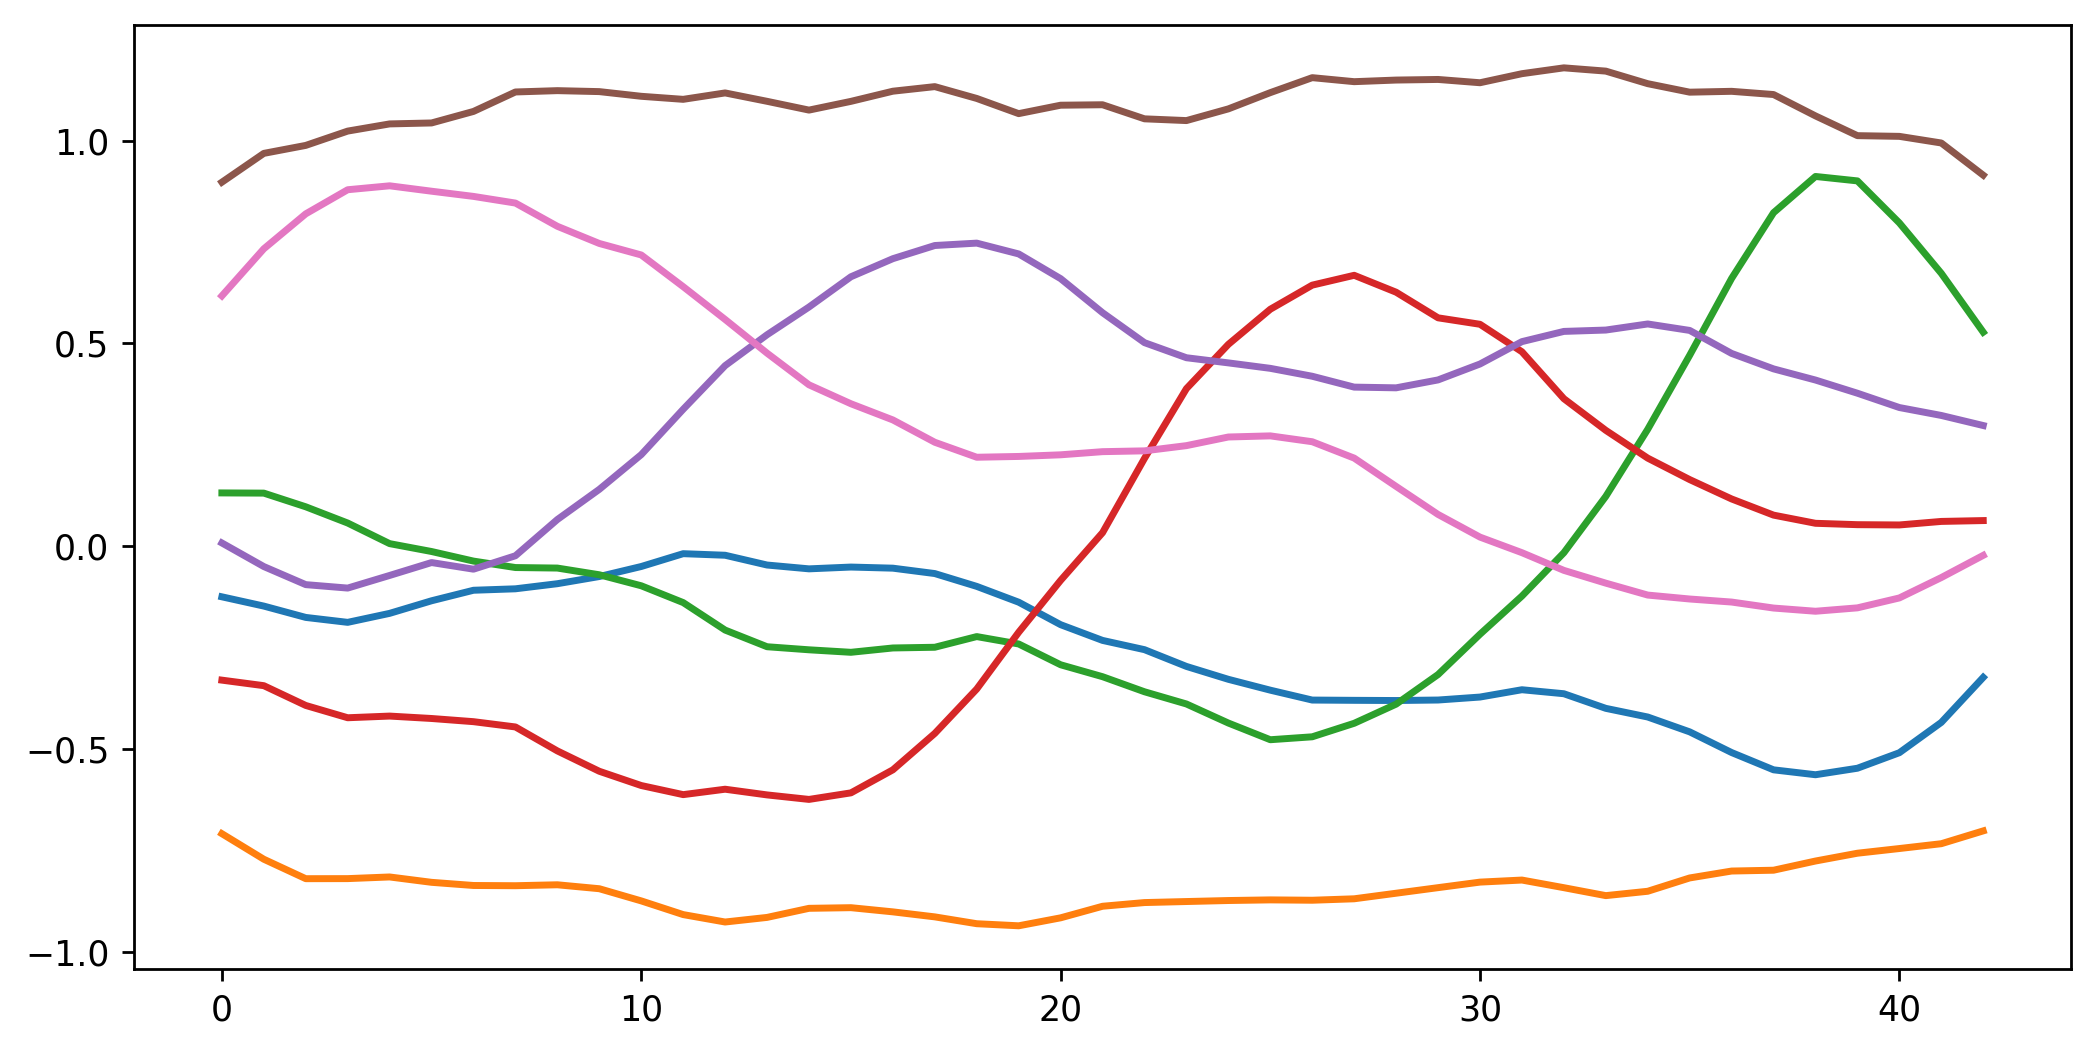

In [71]:
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    plt.plot(shp, linewidth=2)

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 250
plt.savefig("shapelet_bin.pdf", bbox_inches='tight')

# Shaplet-distances-based Classifier


## KNN

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [73]:
X_train2 = shp_clf.transform(X_train)
X_res2 = shp_clf.transform(X_res)
X_test2 = shp_clf.transform(X_test)

X_train2.shape

20/20 [==============================] - 0s 5ms/step


(44306, 7)

In [80]:
param_grid = {'weights': ['uniform', 'distance'],
              'n_neighbors': range(80, 135 +1, 1), #range originale 1 --> 200 +1
              'p': [1, 2]
             }

clf = KNeighborsClassifier()


grid_search = GridSearchCV(clf, param_grid, n_jobs=-1, verbose=10, scoring='accuracy', cv=5)
grid_search.fit(X_train2, y_train)

Fitting 5 folds for each of 224 candidates, totalling 1120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:  

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(80, 136), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=10)

In [81]:
report(grid_search.cv_results_, n_top=10)

Model with rank: 1
Mean validation score: 0.717 (std: 0.002)
Parameters: {'n_neighbors': 123, 'p': 2, 'weights': 'distance'}

Model with rank: 2
Mean validation score: 0.716 (std: 0.002)
Parameters: {'n_neighbors': 121, 'p': 2, 'weights': 'distance'}

Model with rank: 3
Mean validation score: 0.716 (std: 0.002)
Parameters: {'n_neighbors': 117, 'p': 2, 'weights': 'distance'}

Model with rank: 4
Mean validation score: 0.716 (std: 0.002)
Parameters: {'n_neighbors': 118, 'p': 2, 'weights': 'distance'}

Model with rank: 5
Mean validation score: 0.716 (std: 0.003)
Parameters: {'n_neighbors': 135, 'p': 2, 'weights': 'distance'}

Model with rank: 6
Mean validation score: 0.716 (std: 0.002)
Parameters: {'n_neighbors': 127, 'p': 2, 'weights': 'distance'}

Model with rank: 7
Mean validation score: 0.716 (std: 0.002)
Parameters: {'n_neighbors': 119, 'p': 2, 'weights': 'distance'}

Model with rank: 8
Mean validation score: 0.716 (std: 0.002)
Parameters: {'n_neighbors': 129, 'p': 2, 'weights': 'dist

In [82]:
#clf = KNeighborsClassifier(n_neighbors=91, p=1, weights='distance') #migliore bilanciato (.653)

clf = KNeighborsClassifier(n_neighbors=109, p=2, weights='distance', n_jobs=-1) #migliore sbilanciato (.719)

clf.fit(X_train2, y_train)

y_pred = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))


Accuracy 0.7182612228316068
F1-score [0.82716511 0.23833059]
              precision    recall  f1-score   support

           0       0.73      0.95      0.83      3508
           1       0.53      0.15      0.24      1415

    accuracy                           0.72      4923
   macro avg       0.63      0.55      0.53      4923
weighted avg       0.68      0.72      0.66      4923



In [11]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=None, random_state=42, class_weight='balanced', criterion='entropy', min_samples_leaf=136, min_samples_split=2) #migliore sbilanciato .634
#clf = DecisionTreeClassifier(max_depth=6, random_state=42, criterion='entropy', min_samples_leaf=112, min_samples_split=2) #migliore bilanciato 652

clf.fit(X_train2, y_train)

y_pred = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

NameError: name 'X_train2' is not defined

In [95]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators': range(100, 2000, 100),
              'criterion': ['gini', 'entropy'],
             }

clf = RandomForestClassifier(
                             max_depth=None, 
                             min_samples_split=10, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             random_state=0,
                             class_weight = 'balanced',
                             verbose=0,
                             n_jobs=-1,
                             oob_score=True)


grid_search = GridSearchCV(clf, param_grid, n_jobs=1, verbose=10, scoring='accuracy', cv=3)
grid_search.fit(X_train2, y_train)

Fitting 3 folds for each of 38 candidates, totalling 114 fits
[CV] criterion=gini, n_estimators=100 ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .... criterion=gini, n_estimators=100, score=0.704, total=   4.6s
[CV] criterion=gini, n_estimators=100 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


[CV] .... criterion=gini, n_estimators=100, score=0.707, total=   1.2s
[CV] criterion=gini, n_estimators=100 ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s


[CV] .... criterion=gini, n_estimators=100, score=0.705, total=   1.2s
[CV] criterion=gini, n_estimators=200 ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.0s remaining:    0.0s


[CV] .... criterion=gini, n_estimators=200, score=0.707, total=   2.2s
[CV] criterion=gini, n_estimators=200 ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.2s remaining:    0.0s


[CV] .... criterion=gini, n_estimators=200, score=0.708, total=   2.3s
[CV] criterion=gini, n_estimators=200 ................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.5s remaining:    0.0s


[CV] .... criterion=gini, n_estimators=200, score=0.705, total=   2.3s
[CV] criterion=gini, n_estimators=300 ................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   13.9s remaining:    0.0s


[CV] .... criterion=gini, n_estimators=300, score=0.709, total=   3.3s
[CV] criterion=gini, n_estimators=300 ................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   17.2s remaining:    0.0s


[CV] .... criterion=gini, n_estimators=300, score=0.709, total=   3.4s
[CV] criterion=gini, n_estimators=300 ................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   20.7s remaining:    0.0s


[CV] .... criterion=gini, n_estimators=300, score=0.706, total=   3.4s
[CV] criterion=gini, n_estimators=400 ................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   24.1s remaining:    0.0s


[CV] .... criterion=gini, n_estimators=400, score=0.707, total=   4.3s
[CV] criterion=gini, n_estimators=400 ................................
[CV] .... criterion=gini, n_estimators=400, score=0.709, total=   4.5s
[CV] criterion=gini, n_estimators=400 ................................
[CV] .... criterion=gini, n_estimators=400, score=0.705, total=   4.6s
[CV] criterion=gini, n_estimators=500 ................................
[CV] .... criterion=gini, n_estimators=500, score=0.707, total=   5.5s
[CV] criterion=gini, n_estimators=500 ................................
[CV] .... criterion=gini, n_estimators=500, score=0.709, total=   5.6s
[CV] criterion=gini, n_estimators=500 ................................
[CV] .... criterion=gini, n_estimators=500, score=0.707, total=   5.9s
[CV] criterion=gini, n_estimators=600 ................................
[CV] .... criterion=gini, n_estimators=600, score=0.708, total=   6.6s
[CV] criterion=gini, n_estimators=600 ................................
[CV] .

[CV] . criterion=entropy, n_estimators=400, score=0.710, total=   5.2s
[CV] criterion=entropy, n_estimators=400 .............................
[CV] . criterion=entropy, n_estimators=400, score=0.707, total=   5.3s
[CV] criterion=entropy, n_estimators=500 .............................
[CV] . criterion=entropy, n_estimators=500, score=0.708, total=   6.4s
[CV] criterion=entropy, n_estimators=500 .............................
[CV] . criterion=entropy, n_estimators=500, score=0.710, total=   6.5s
[CV] criterion=entropy, n_estimators=500 .............................
[CV] . criterion=entropy, n_estimators=500, score=0.705, total=   6.7s
[CV] criterion=entropy, n_estimators=600 .............................
[CV] . criterion=entropy, n_estimators=600, score=0.708, total=   7.9s
[CV] criterion=entropy, n_estimators=600 .............................
[CV] . criterion=entropy, n_estimators=600, score=0.710, total=   7.9s
[CV] criterion=entropy, n_estimators=600 .............................
[CV] .

[Parallel(n_jobs=1)]: Done 114 out of 114 | elapsed: 25.1min finished


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              min_samples_split=10, n_jobs=-1,
                                              oob_score=True, random_state=0),
             n_jobs=1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': range(100, 2000, 100)},
             scoring='accuracy', verbose=10)

In [97]:
report(grid_search.cv_results_, n_top=20)

Model with rank: 1
Mean validation score: 0.709 (std: 0.001)
Parameters: {'criterion': 'entropy', 'n_estimators': 1700}

Model with rank: 2
Mean validation score: 0.709 (std: 0.001)
Parameters: {'criterion': 'entropy', 'n_estimators': 1900}

Model with rank: 3
Mean validation score: 0.709 (std: 0.001)
Parameters: {'criterion': 'entropy', 'n_estimators': 1400}

Model with rank: 4
Mean validation score: 0.709 (std: 0.001)
Parameters: {'criterion': 'entropy', 'n_estimators': 1600}

Model with rank: 5
Mean validation score: 0.709 (std: 0.001)
Parameters: {'criterion': 'entropy', 'n_estimators': 1800}

Model with rank: 6
Mean validation score: 0.709 (std: 0.002)
Parameters: {'criterion': 'entropy', 'n_estimators': 1300}

Model with rank: 7
Mean validation score: 0.709 (std: 0.001)
Parameters: {'criterion': 'entropy', 'n_estimators': 1500}

Model with rank: 8
Mean validation score: 0.709 (std: 0.002)
Parameters: {'criterion': 'entropy', 'n_estimators': 1200}

Model with rank: 9
Mean validati

In [98]:
clf = RandomForestClassifier(n_estimators=1100, 
                             criterion='entropy', 
                             max_depth=None, 
                             min_samples_split=10, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             random_state=0,
                             class_weight = 'balanced',
                             verbose=0,
                             n_jobs=-1,
                             oob_score=True)


clf.fit(X_train2, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       min_samples_split=10, n_estimators=1100, n_jobs=-1,
                       oob_score=True, random_state=0)

In [99]:
y_pred = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.708714198659354
F1-score [0.80951116 0.38136324]
              precision    recall  f1-score   support

           0       0.76      0.87      0.81      3508
           1       0.49      0.31      0.38      1415

    accuracy                           0.71      4923
   macro avg       0.62      0.59      0.60      4923
weighted avg       0.68      0.71      0.69      4923



# Feature-based Classifier

In [100]:
import scipy.stats as stats

def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        #'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

X_train3 = np.array([list(calculate_features(x).values()) for x in X_train])
X_res3 = np.array([list(calculate_features(x).values()) for x in X_res])
X_test3 = np.array([list(calculate_features(x).values()) for x in X_test])

X_train3.shape

(44306, 12)

In [104]:
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [None] + list(range(1, 10 +1, 1)), #range originale 4, 40+1, 4
              'min_samples_split': range(2, 20 +1, 5), #2, 150+1, 10
              'min_samples_leaf': range(130, 200 +1, 5), #2, 150+1, 10
              'class_weight': ['balanced']
             }

clf = DecisionTreeClassifier()


grid_search = GridSearchCV(clf, param_grid, n_jobs=-1, verbose=10, scoring='accuracy', cv=5)
grid_search.fit(X_train3, y_train)

Fitting 5 folds for each of 1320 candidates, totalling 6600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:  

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': range(130, 201, 5),
                         'min_samples_split': range(2, 21, 5)},
             scoring='accuracy', verbose=10)

In [105]:
report(grid_search.cv_results_, n_top=5)

Model with rank: 1
Mean validation score: 0.621 (std: 0.007)
Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 140, 'min_samples_split': 2}

Model with rank: 1
Mean validation score: 0.621 (std: 0.007)
Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 140, 'min_samples_split': 17}

Model with rank: 3
Mean validation score: 0.621 (std: 0.007)
Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 140, 'min_samples_split': 7}

Model with rank: 3
Mean validation score: 0.621 (std: 0.007)
Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 140, 'min_samples_split': 12}

Model with rank: 5
Mean validation score: 0.620 (std: 0.006)
Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 130, 'min_samples_split': 7}

Model with rank: 5
Mean validation sco

In [106]:
#clf = DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=185, min_samples_split=2) #Migliore bilanciato 0.658
clf = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=None, min_samples_leaf=140, min_samples_split=2) #Migliore sbilanciato .665
clf.fit(X_train3, y_train)

y_pred = clf.predict(X_test3)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.6215722120658135
F1-score [0.69907931 0.49028728]
              precision    recall  f1-score   support

           0       0.81      0.62      0.70      3508
           1       0.40      0.63      0.49      1415

    accuracy                           0.62      4923
   macro avg       0.60      0.63      0.59      4923
weighted avg       0.69      0.62      0.64      4923



In [107]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators': range(100, 1700, 100),
              'criterion': ['gini', 'entropy'],
             }

clf = RandomForestClassifier(
                             max_depth=None, 
                             min_samples_split=10, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             random_state=0,
                             class_weight = 'balanced',
                             verbose=0,
                             n_jobs=-1,
                             oob_score=True)


grid_search = GridSearchCV(clf, param_grid, n_jobs=2, verbose=10, scoring='accuracy', cv=3)
grid_search.fit(X_train3, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    4.6s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   11.2s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   21.4s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   42.4s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  3.5min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  5.8min
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:  8.8min finished


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              min_samples_split=10, n_jobs=-1,
                                              oob_score=True, random_state=0),
             n_jobs=2,
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': range(100, 1700, 100)},
             scoring='accuracy', verbose=10)

In [110]:
report(grid_search.cv_results_, n_top=20)

Model with rank: 1
Mean validation score: 0.714 (std: 0.002)
Parameters: {'criterion': 'entropy', 'n_estimators': 1100}

Model with rank: 2
Mean validation score: 0.714 (std: 0.002)
Parameters: {'criterion': 'entropy', 'n_estimators': 1000}

Model with rank: 3
Mean validation score: 0.714 (std: 0.001)
Parameters: {'criterion': 'entropy', 'n_estimators': 1400}

Model with rank: 4
Mean validation score: 0.714 (std: 0.002)
Parameters: {'criterion': 'entropy', 'n_estimators': 1300}

Model with rank: 5
Mean validation score: 0.714 (std: 0.002)
Parameters: {'criterion': 'entropy', 'n_estimators': 1200}

Model with rank: 6
Mean validation score: 0.714 (std: 0.002)
Parameters: {'criterion': 'entropy', 'n_estimators': 1500}

Model with rank: 7
Mean validation score: 0.714 (std: 0.002)
Parameters: {'criterion': 'entropy', 'n_estimators': 900}

Model with rank: 8
Mean validation score: 0.714 (std: 0.002)
Parameters: {'criterion': 'entropy', 'n_estimators': 800}

Model with rank: 9
Mean validation

In [113]:
clf = RandomForestClassifier(n_estimators=800, 
                             criterion='entropy', 
                             max_depth=None, 
                             min_samples_split=10, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             random_state=0,
                             class_weight = 'balanced',
                             verbose=0,
                             n_jobs=-1,
                             oob_score=True)


clf.fit(X_train3, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       min_samples_split=10, n_estimators=800, n_jobs=-1,
                       oob_score=True, random_state=0)

In [114]:
y_pred = clf.predict(X_test3)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7257769652650823
F1-score [0.82119205 0.41202091]
              precision    recall  f1-score   support

           0       0.77      0.88      0.82      3508
           1       0.54      0.33      0.41      1415

    accuracy                           0.73      4923
   macro avg       0.65      0.61      0.62      4923
weighted avg       0.70      0.73      0.70      4923



# Time Series Classifier

In [10]:
from tslearn.piecewise import PiecewiseAggregateApproximation
paa = PiecewiseAggregateApproximation(n_segments=129)


X_train_paa = paa.fit_transform(X_train).squeeze()
X_res_paa = paa.fit_transform(X_res).squeeze()
X_test_paa = paa.fit_transform(X_test).squeeze()

C:\Users\cri98\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 44306 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
C:\Users\cri98\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 25460 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
C:\Users\cri98\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 4923 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


## KNN

In [17]:
param_grid = {'weights': ['distance'],
              'n_neighbors': [50, 100, 150], #range originale 1 --> 200 +1
              'p': [1, 2]
             }

clf = KNeighborsClassifier(n_jobs=11)


grid_search = GridSearchCV(clf, param_grid, n_jobs=2, verbose=10, scoring='accuracy', cv=3)
grid_search.fit(X_train_paa[:500], y_train[:500])

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Batch computation too fast (0.0170s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Batch computation too fast (0.0380s.) Setting batch_size=4.
[Parallel(n_jobs=2)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  18 out of  18 | elapsed:    0.0s finished


GridSearchCV(cv=3, estimator=KNeighborsClassifier(n_jobs=11), n_jobs=2,
             param_grid={'n_neighbors': [50, 100, 150], 'p': [1, 2],
                         'weights': ['distance']},
             scoring='accuracy', verbose=10)

In [18]:
report(grid_search.cv_results_, n_top=5) 

Model with rank: 1
Mean validation score: 0.720 (std: 0.005)
Parameters: {'n_neighbors': 50, 'p': 1, 'weights': 'distance'}

Model with rank: 1
Mean validation score: 0.720 (std: 0.002)
Parameters: {'n_neighbors': 100, 'p': 1, 'weights': 'distance'}

Model with rank: 1
Mean validation score: 0.720 (std: 0.002)
Parameters: {'n_neighbors': 100, 'p': 2, 'weights': 'distance'}

Model with rank: 1
Mean validation score: 0.720 (std: 0.002)
Parameters: {'n_neighbors': 150, 'p': 1, 'weights': 'distance'}

Model with rank: 1
Mean validation score: 0.720 (std: 0.002)
Parameters: {'n_neighbors': 150, 'p': 2, 'weights': 'distance'}



In [21]:
#clf = KNeighborsClassifier(n_neighbors=8, weights='uniform', n_jobs=-1) #.58 con uniforme e 8 vicini bilanciato
clf = KNeighborsClassifier(n_neighbors=100, weights='distance', n_jobs=22) #.716 con distance e 100 vicini sbilanciato

scaler = TimeSeriesScalerMinMax()
#X = scaler.fit_transform(X).reshape(X.shape[0], X.shape[1])

clf.fit(X_train_paa[:500], y_train[:500])

y_pred = clf.predict(X_test_paa)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7125736339630306
F1-score [0.832167 0.      ]
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      3508
           1       0.00      0.00      0.00      1415

    accuracy                           0.71      4923
   macro avg       0.36      0.50      0.42      4923
weighted avg       0.51      0.71      0.59      4923



C:\Users\cri98\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [124]:
X_train.shape

(44306, 1292)

In [125]:
scaler.fit_transform(X)[:,:,0].shape

(49229, 1292)

## DT

In [13]:
param_grid = {'criterion': ['gini'],
              'max_depth': [None] + list(range(5, 10 +1, 1)), #[None] + list(range(5, 15 +1, 3))
              'min_samples_split': [42], #range(2, 40 +1, 10)
              'min_samples_leaf': [100], #100, 140+1, 20
              'class_weight': ['balanced'] #non conviene
             }

clf = DecisionTreeClassifier()


grid_search = GridSearchCV(clf, param_grid, n_jobs=-1, verbose=10, scoring='accuracy', cv=3)
grid_search.fit(X_train_paa[:500], y_train[:500])

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  21 | elapsed:    3.2s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done   7 out of  21 | elapsed:    3.2s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done  10 out of  21 | elapsed:    3.3s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  13 out of  21 | elapsed:    3.4s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:    3.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  19 out of  21 | elapsed:    3.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    3.6s finished


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['gini'],
                         'max_depth': [None, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [100], 'min_samples_split': [42]},
             scoring='accuracy', verbose=10)

In [14]:
report(grid_search.cv_results_, n_top=10) #sbil = .715 {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 140, 'min_samples_split': 2}

Model with rank: 1
Mean validation score: 0.544 (std: 0.082)
Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 100, 'min_samples_split': 42}

Model with rank: 1
Mean validation score: 0.544 (std: 0.082)
Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 100, 'min_samples_split': 42}

Model with rank: 1
Mean validation score: 0.544 (std: 0.082)
Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 100, 'min_samples_split': 42}

Model with rank: 1
Mean validation score: 0.544 (std: 0.082)
Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 100, 'min_samples_split': 42}

Model with rank: 1
Mean validation score: 0.544 (std: 0.082)
Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 100, 'min_samples_split': 42}

Model with rank: 1
Mean validation score: 0.544

In [132]:
clf = DecisionTreeClassifier(max_depth=5, min_samples_leaf=100, min_samples_split=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7176518383099736
F1-score [0.81999482 0.34557439]
              precision    recall  f1-score   support

           0       0.75      0.90      0.82      3508
           1       0.52      0.26      0.35      1415

    accuracy                           0.72      4923
   macro avg       0.63      0.58      0.58      4923
weighted avg       0.68      0.72      0.68      4923



## KNN pyts

In [11]:
from pyts.classification import KNeighborsClassifier

clf = KNeighborsClassifier(metric='dtw_sakoechiba', n_jobs=22, n_neighbors=5)
clf.fit(X_res_paa[:500], y_res[:500])

y_pred = clf.predict(X_test_paa)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7125736339630306
F1-score [0.832167 0.      ]
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      3508
           1       0.00      0.00      0.00      1415

    accuracy                           0.71      4923
   macro avg       0.36      0.50      0.42      4923
weighted avg       0.51      0.71      0.59      4923



C:\Users\cri98\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Da Qui è OPZIONALE

## CNN Classifier


In [135]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling1D
from keras.layers import Conv1D, Activation, Conv1D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

def build_simple_cnn(n_timesteps, n_outputs):
    model = Sequential()
    
    model.add(Conv1D(filters=16, kernel_size=8, activation='relu', input_shape=(n_timesteps, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(GlobalAveragePooling1D())
    
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train_cnn, y_train, test_size=0.2, stratify=y_train)

n_timesteps, n_outputs, n_features = X_train_cnn.shape[1], len(np.unique(y_train_cnn)), 1 
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

cnn = build_simple_cnn(n_timesteps, n_outputs)

cnn.summary()

TIMESTEPS:  1292
N. LABELS:  2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 1285, 16)          144       
_________________________________________________________________
batch_normalization_3 (Batch (None, 1285, 16)          64        
_________________________________________________________________
activation_3 (Activation)    (None, 1285, 16)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1285, 16)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1281, 32)          2592      
_________________________________________________________________
batch_normalization_4 (Batch (None, 1281, 32)          128       
_________________________________________________________________
activation_4 (Activatio

In [136]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.0001)
mc = ModelCheckpoint('best_model_cnn.h5', monitor='val_loss', save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=10)

callbacks = [rlr, mc, es]

batch_size = 32
mini_batch_size = int(min(X_train_cnn.shape[0]/10, batch_size))


history_cnn = cnn.fit(X_train_cnn, y_train_cnn, epochs=1000, batch_size=mini_batch_size, callbacks=callbacks,
                      validation_data=(X_val_cnn, y_val_cnn)).history



Epoch 1/1000
1108/1108 [==============================] - 18s 15ms/step - loss: 0.5482 - accuracy: 0.7277 - val_loss: 0.5051 - val_accuracy: 0.7855
Epoch 2/1000
1108/1108 [==============================] - 17s 15ms/step - loss: 0.4796 - accuracy: 0.7863 - val_loss: 0.4673 - val_accuracy: 0.7879
Epoch 3/1000
1108/1108 [==============================] - 17s 15ms/step - loss: 0.4647 - accuracy: 0.7933 - val_loss: 0.5789 - val_accuracy: 0.7397
Epoch 4/1000
1108/1108 [==============================] - 17s 15ms/step - loss: 0.4597 - accuracy: 0.7983 - val_loss: 0.4523 - val_accuracy: 0.8046
Epoch 5/1000
1108/1108 [==============================] - 17s 15ms/step - loss: 0.4619 - accuracy: 0.7962 - val_loss: 0.4679 - val_accuracy: 0.7832
Epoch 6/1000
1108/1108 [==============================] - 17s 15ms/step - loss: 0.4581 - accuracy: 0.7965 - val_loss: 0.4554 - val_accuracy: 0.8044
Epoch 7/1000
1108/1108 [==============================] - 17s 15ms/step - loss: 0.4463 - accuracy: 0.8049 - val_

1108/1108 [==============================] - 17s 15ms/step - loss: 0.4207 - accuracy: 0.8187 - val_loss: 0.4218 - val_accuracy: 0.8153
Epoch 57/1000
1108/1108 [==============================] - 17s 15ms/step - loss: 0.4186 - accuracy: 0.8170 - val_loss: 0.4219 - val_accuracy: 0.8181
Epoch 58/1000
1108/1108 [==============================] - 17s 15ms/step - loss: 0.4202 - accuracy: 0.8199 - val_loss: 0.4276 - val_accuracy: 0.8180
Epoch 59/1000
1108/1108 [==============================] - 17s 15ms/step - loss: 0.4188 - accuracy: 0.8171 - val_loss: 0.4220 - val_accuracy: 0.8181
Epoch 60/1000
1108/1108 [==============================] - 17s 15ms/step - loss: 0.4200 - accuracy: 0.8180 - val_loss: 0.4214 - val_accuracy: 0.8184
Epoch 61/1000
1108/1108 [==============================] - 17s 15ms/step - loss: 0.4166 - accuracy: 0.8215 - val_loss: 0.4249 - val_accuracy: 0.8186
Epoch 62/1000
1108/1108 [==============================] - 17s 15ms/step - loss: 0.4167 - accuracy: 0.8227 - val_loss: 0

In [137]:
y_pred = np.argmax(cnn.predict(X_test_cnn), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.8159658744667886
F1-score [0.88034865 0.60158311]
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      3508
           1       0.80      0.48      0.60      1415

    accuracy                           0.82      4923
   macro avg       0.81      0.72      0.74      4923
weighted avg       0.81      0.82      0.80      4923



# LSTM Classifier

In [42]:
from keras.layers import LSTM

def build_lstm(n_timesteps, n_outputs):
    model = Sequential()
    model.add(LSTM(256, input_shape=(n_timesteps, 1)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_outputs, activation='sigmoid'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

lstm = build_lstm(n_timesteps, n_outputs)

lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               264192    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 280,770
Trainable params: 280,770
Non-trainable params: 0
_________________________________________________________________


In [43]:
history_lstm = cnn.fit(X_train_cnn, y_train_cnn, epochs=1000, batch_size=mini_batch_size, callbacks=callbacks,
                       validation_data=(X_val_cnn, y_val_cnn)).history

Epoch 1/50
1108/1108 [==============================] - 17s 15ms/step - loss: 0.4361 - accuracy: 0.8061 - val_loss: 0.4697 - val_accuracy: 0.7925
Epoch 2/50
1108/1108 [==============================] - 16s 15ms/step - loss: 0.4377 - accuracy: 0.8057 - val_loss: 0.4643 - val_accuracy: 0.7901
Epoch 3/50
1108/1108 [==============================] - 16s 15ms/step - loss: 0.4357 - accuracy: 0.8071 - val_loss: 0.4490 - val_accuracy: 0.8006
Epoch 4/50
1108/1108 [==============================] - 16s 15ms/step - loss: 0.4341 - accuracy: 0.8067 - val_loss: 0.4521 - val_accuracy: 0.8095
Epoch 5/50
1108/1108 [==============================] - 16s 15ms/step - loss: 0.4338 - accuracy: 0.8072 - val_loss: 0.4635 - val_accuracy: 0.7924
Epoch 6/50
1108/1108 [==============================] - 16s 15ms/step - loss: 0.4338 - accuracy: 0.8100 - val_loss: 0.5085 - val_accuracy: 0.7590
Epoch 7/50
1108/1108 [==============================] - 16s 15ms/step - loss: 0.4346 - accuracy: 0.8079 - val_loss: 0.4587 -

In [45]:
y_pred = np.argmax(lstm.predict(X_test_cnn), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.3053016453382084
F1-score [0.05888828 0.44945267]
              precision    recall  f1-score   support

           0       0.85      0.03      0.06      3508
           1       0.29      0.99      0.45      1415

    accuracy                           0.31      4923
   macro avg       0.57      0.51      0.25      4923
weighted avg       0.69      0.31      0.17      4923



# Multivariate Time Series Classifiers

In [46]:
from pyts.datasets import load_basic_motions

from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score


In [48]:
n_timesteps, n_outputs, n_features = X_train.shape[1], len(np.unique(y_train)), X_train.shape[2] 

X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [49]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, Conv2D, MaxPool2D, Flatten, Dropout, LeakyReLU, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint



def build_lstm2(n_timesteps, n_outputs, n_features):
    model = Sequential()
    model.add(LSTM(4, input_shape=(n_timesteps, n_features), return_sequences=True, 
                        kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    #1
    for _ in range(2):
        model.add(LSTM(4, kernel_initializer='TruncatedNormal', return_sequences=True))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.04))   

    #2
    model.add(LSTM(32, kernel_initializer='TruncatedNormal', return_sequences=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.7))
    
    #3
    for _ in range(2):
        model.add(Dense(256, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.2))
    #4
    for _ in range(1):
        model.add(Dense(64, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.7))

    #5
    model.add(Dense(32, kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
        
    model.add(Dense(n_outputs, activation='sigmoid'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


lstm2 = build_lstm2(n_timesteps, n_outputs, n_features)

lstm2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1292, 4)           96        
_________________________________________________________________
batch_normalization_6 (Batch (None, 1292, 4)           16        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1292, 4)           0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1292, 4)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1292, 4)           144       
_________________________________________________________________
batch_normalization_7 (Batch (None, 1292, 4)           16        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1292, 4)          

In [52]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=0.0001)
mc = ModelCheckpoint('best_model_lstm2.h5', monitor='val_loss', save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=10)

callbacks = [rlr, mc, es]

batch_size = 1024
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

history_lstm2 = lstm2.fit(X_train_cnn, y_train_cnn, epochs=50, batch_size=mini_batch_size, callbacks=callbacks,
                          validation_data=(X_val_cnn, y_val_cnn)).history

Epoch 1/50
35/35 [==============================] - 10s 290ms/step - loss: 0.5627 - accuracy: 0.7120 - val_loss: 0.9034 - val_accuracy: 0.3099
Epoch 2/50
35/35 [==============================] - 10s 290ms/step - loss: 0.5677 - accuracy: 0.7108 - val_loss: 0.9061 - val_accuracy: 0.7127
Epoch 3/50
35/35 [==============================] - 10s 291ms/step - loss: 0.5622 - accuracy: 0.7115 - val_loss: 0.6111 - val_accuracy: 0.7127
Epoch 4/50
35/35 [==============================] - 10s 292ms/step - loss: 0.5620 - accuracy: 0.7115 - val_loss: 0.5750 - val_accuracy: 0.7127
Epoch 5/50
35/35 [==============================] - 10s 300ms/step - loss: 0.5657 - accuracy: 0.7115 - val_loss: 0.5640 - val_accuracy: 0.7127
Epoch 6/50
35/35 [==============================] - 11s 303ms/step - loss: 0.5618 - accuracy: 0.7120 - val_loss: 0.6503 - val_accuracy: 0.5334
Epoch 7/50
35/35 [==============================] - 10s 300ms/step - loss: 0.5620 - accuracy: 0.7120 - val_loss: 0.6245 - val_accuracy: 0.7127

KeyboardInterrupt: 

In [ ]:
y_pred = np.argmax(lstm2.predict(X_test), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

In [54]:
X_train_cnn2 = X_train_cnn.reshape(X_train_cnn.shape[0], X_train_cnn.shape[1], X_train_cnn.shape[2], 1)
X_val_cnn2 = X_val_cnn.reshape(X_val_cnn.shape[0], X_val_cnn.shape[1], X_val_cnn.shape[2], 1)
X_test_cnn2 = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

X_train_cnn2.shape

(35444, 1292, 1, 1)

In [55]:
def build_cnn2(n_timesteps, n_features, n_outputs):
    input_shape = (n_timesteps, n_features, 1)

    model = Sequential()
    
    ks1_first = 3
    ks1_second = 3
    
    ks2_first = 4
    ks2_second = 4
    
    model.add(Conv2D(filters=(3), 
                     kernel_size=(ks1_first, ks1_second),
                     input_shape=input_shape, 
                     padding='same',
                     kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.02))
    
    for _ in range(2):
        model.add(Conv2D(filters=(4), 
                     kernel_size= (ks2_first, ks2_second), 
                         padding='same',
                     kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.2))  
    
    model.add(Flatten())
    
    for _ in range(4):
        model.add(Dense(64 , kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.4))
    
    for _ in range(3):
        model.add(Dense(128 , kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.3))
  
    model.add(Dense(1024 , kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.7))
        
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


cnn2 = build_cnn2(n_timesteps, n_features, n_outputs)

cnn2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1292, 1, 3)        30        
_________________________________________________________________
batch_normalization_14 (Batc (None, 1292, 1, 3)        12        
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 1292, 1, 3)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 1292, 1, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1292, 1, 4)        196       
_________________________________________________________________
batch_normalization_15 (Batc (None, 1292, 1, 4)        16        
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 1292, 1, 4)       

In [58]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=0.0001)
mc = ModelCheckpoint('best_model_lstm2.h5', monitor='val_loss', save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=10)

callbacks = [rlr, mc, es]

batch_size = 64
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

In [59]:
history_cnn2 = cnn2.fit(X_train_cnn2, y_train_cnn, epochs=1000, batch_size=mini_batch_size, callbacks=callbacks,
                      validation_data=(X_val_cnn2, y_val_cnn)).history

Epoch 1/1000
554/554 [==============================] - 10s 18ms/step - loss: 0.6041 - accuracy: 0.7019 - val_loss: 0.5700 - val_accuracy: 0.7127
Epoch 2/1000
554/554 [==============================] - 10s 17ms/step - loss: 0.5851 - accuracy: 0.7057 - val_loss: 0.5609 - val_accuracy: 0.7127
Epoch 3/1000
554/554 [==============================] - 9s 17ms/step - loss: 0.5835 - accuracy: 0.7059 - val_loss: 0.5623 - val_accuracy: 0.7127
Epoch 4/1000
554/554 [==============================] - 10s 17ms/step - loss: 0.5854 - accuracy: 0.7051 - val_loss: 0.5952 - val_accuracy: 0.7127
Epoch 5/1000
554/554 [==============================] - 10s 17ms/step - loss: 0.5805 - accuracy: 0.7060 - val_loss: 0.5707 - val_accuracy: 0.7179
Epoch 6/1000
554/554 [==============================] - 10s 17ms/step - loss: 0.5707 - accuracy: 0.7134 - val_loss: 0.5787 - val_accuracy: 0.7235
Epoch 7/1000
554/554 [==============================] - 9s 17ms/step - loss: 0.5663 - accuracy: 0.7194 - val_loss: 0.5493 - v

In [60]:
y_pred = np.argmax(cnn2.predict(X_test_cnn2), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.732480195003047
F1-score [0.80514869 0.57337221]
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      3508
           1       0.53      0.63      0.57      1415

    accuracy                           0.73      4923
   macro avg       0.68      0.70      0.69      4923
weighted avg       0.75      0.73      0.74      4923



In [61]:
def build_cnn3(n_timesteps, n_outputs, n_features):
    model = Sequential()
    
    model.add(Conv1D(filters=16, kernel_size=8, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(GlobalAveragePooling1D())
    
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


cnn3 = build_cnn3(n_timesteps, n_outputs, n_features)

cnn3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 1285, 16)          144       
_________________________________________________________________
batch_normalization_25 (Batc (None, 1285, 16)          64        
_________________________________________________________________
activation_6 (Activation)    (None, 1285, 16)          0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 1285, 16)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1281, 32)          2592      
_________________________________________________________________
batch_normalization_26 (Batc (None, 1281, 32)          128       
_________________________________________________________________
activation_7 (Activation)    (None, 1281, 32)         

In [62]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=0.0001)
mc = ModelCheckpoint('best_model_lstm2.h5', monitor='val_loss', save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=10)

callbacks = [rlr, mc, es]

batch_size = 32
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))


history_cnn3 = cnn3.fit(X_train_cnn, y_train_cnn, epochs=1000, batch_size=mini_batch_size, callbacks=callbacks,
                      validation_data=(X_val_cnn, y_val_cnn)).history

Epoch 1/1000
1108/1108 [==============================] - 18s 15ms/step - loss: 0.5246 - accuracy: 0.7512 - val_loss: 0.5065 - val_accuracy: 0.7483
Epoch 2/1000
1108/1108 [==============================] - 16s 15ms/step - loss: 0.4770 - accuracy: 0.7827 - val_loss: 0.5081 - val_accuracy: 0.7405
Epoch 3/1000
1108/1108 [==============================] - 16s 15ms/step - loss: 0.4688 - accuracy: 0.7884 - val_loss: 0.4596 - val_accuracy: 0.7949
Epoch 4/1000
1108/1108 [==============================] - 16s 15ms/step - loss: 0.4686 - accuracy: 0.7895 - val_loss: 0.4882 - val_accuracy: 0.7804
Epoch 5/1000
1108/1108 [==============================] - 16s 15ms/step - loss: 0.4618 - accuracy: 0.7936 - val_loss: 0.4860 - val_accuracy: 0.7595
Epoch 6/1000
1108/1108 [==============================] - 16s 15ms/step - loss: 0.4766 - accuracy: 0.7854 - val_loss: 0.4782 - val_accuracy: 0.7852
Epoch 7/1000
1108/1108 [==============================] - 16s 15ms/step - loss: 0.4634 - accuracy: 0.7902 - val_

In [63]:
y_pred = np.argmax(cnn3.predict(X_test), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7844810075157425
F1-score [0.84731616 0.63375906]
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      3508
           1       0.62      0.65      0.63      1415

    accuracy                           0.78      4923
   macro avg       0.74      0.74      0.74      4923
weighted avg       0.79      0.78      0.79      4923

